# Capstone 2 Project: Customer Churn
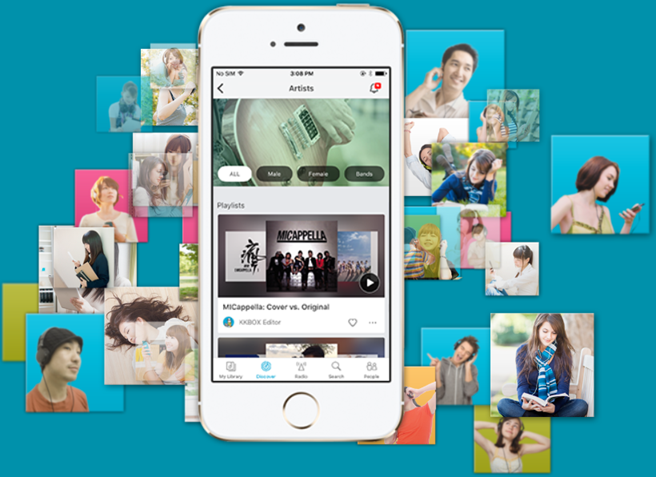

## 1. Problem Identification
### 1.1 Context
<a href="https://www.kkbox.com/">KKBOX</a> is Asia’s leading music streaming service, holding the world’s most comprehensive Asia-Pop music library with over 30 million tracks. They offer a generous, unlimited version of their service to millions of people, supported by advertising and paid subscriptions. This delicate model is dependent on accurately predicting churn of their paid users.<br>
When users sign up for the service, they can choose to either manual renew or auto-renew the service, and they can cancel their membership at any time.

Build an algorithm that predicts whether a user will churn after their subscription expires. Specifically, we want to forecast if a user will make a new service subscription transaction within 30 days after the current membership expiration date.

### 1.2 Criteria for success
Prediction accuracy of the trained machine learning model does not deteriorate when applied to new, more recent data. Decision criteria are simple and interpretable. If using a decision tree, no more than 10 questions asked before making a prediction.

### 1.3 Scope of solution space
Since the majority of KKBox's subscription length is 30 days, a lot of users re-subscribe every month. The key fields to determine churn/renewal are `transaction date`, `membership expiration date`, and `is_cancel`.
The `is_cancel` field indicates whether a user actively cancels a subscription. Subscription cancellation does not imply the user has churned. A user may cancel service subscription due to change of service plans or other reasons. The criteria of <b>"churn"</b> is no new valid service subscription within 30 days after the current membership expires.<br>
Supervised learning methods will be used to handle this binary classification problem. Some of the records with missing and erroneous data will be placed in a separate category.

### 1.4 Constraints within solution space
The data may reveal incorrect and missing values. Such problems will be treated individually for different features and depending on the number of problems of specific kind.

The data have a shape that is incompatible with machine learning algorithms, which expect one record per prediction label. Thus, there is in general several transactions and several usage statistics records per member, which have to be aggregated into one row.

SAMPLE:<br>
A warmer or very snowy season can lead to an unpredictable decrease in the number of operating days and additional costs of making or removing excess snow. Large differences in the physical abilities of group members can lead to long waiting times on zip lines and thus to underutilization of facilities. Accidents can lead to the temporary closure of runs.

### 1.5 Stakeholders to provide key insight
There are two key stakeholders that need to be involved in this project: 1) My mentor Rahul Sagrolikar, and 2) Addison Howard, Head of Competition Program Management at Kaggle.

### 1.6 Key data sources
Data were compiled by Ann and Arden from KKBox, and are available at Kaggle
https://www.kaggle.com/c/kkbox-churn-prediction-challenge

Data are provided in 3 CSV files containing basic information about KKBOX customers, transaction details, and listening statistics.
* `members.csv`: city, `bd`, gender, registration channel, initial registration time. 6658 records.
* `transactions.csv`: payment method, duration of subscription plan, listed price, paid price, auto renewal indicator, transaction date, membership expiration date, and the churn label. 22940 records.
* `logs.csv`: date, number of songs listened below 25%, 50%, 75%, 98.5%, and 100% of their duration, number of unique songs listened, and total duration of listening. 424254 records.

In [1]:
# Import data
import os
#os.chdir('C:/Sereda/Lectures/Springboard/16.Feature_Engineering/')
os.chdir('C:/Sereda/Lectures/Springboard/Capstone2_CustomerChurn/')

# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings from pandas
#import warnings
#warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')
pd.set_option('display.max_rows', 600)

## 2.  Data Wrangling: Collect, organize, define, and clean a relevant dataset.
### 2.1 Collect Data

In [4]:
# Data science helpers
from pathlib import Path
#!pip install featuretools==0.4.0 dask==0.19.4 distributed==1.23.3 tornado==5.0.0
import featuretools as ft

# Useful for showing multiple outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# make some folders we will need if they do not exist
Path("./data/churn").mkdir(parents=True, exist_ok=True)

In [5]:
# Read in all data
members = pd.read_csv('https://raw.githubusercontent.com/springboard-curriculum/featuretools/master/data/members.csv', 
                      parse_dates=['registration_init_time'], 
                      infer_datetime_format = True)

trans = pd.read_csv('https://raw.githubusercontent.com/springboard-curriculum/featuretools/master/data/transactions.csv',
                   parse_dates=['transaction_date', 'membership_expire_date'], 
                    infer_datetime_format = True)

logs = pd.read_csv(f'https://raw.githubusercontent.com/springboard-curriculum/featuretools/master/data/logs.csv', parse_dates = ['date'])

cutoff_times = pd.read_csv(f'https://raw.githubusercontent.com/springboard-curriculum/featuretools/master/data/MS-31_labels.csv', parse_dates = ['cutoff_time'])

In [6]:
members = pd.read_csv('https://raw.githubusercontent.com/springboard-curriculum/featuretools/master/data/members.csv', 
                      parse_dates=['registration_init_time'], 
                      infer_datetime_format = True, index_col=False)

In [7]:
members.reset_index(drop=True)

,msno,city,bd,gender,registered_via,registration_init_time
0,8hW4+CV3D1oNM0CIsA39YljsF8M3m7g1LAX6AQd3C8I=,4,24,male,3,2014-11-04
1,yhcODfebyTYezE6KAPklcV1us9zdOYJ+7eHS7f/xgoU=,8,37,male,9,2007-02-11
2,sBlgSL0AIq49XsmBQ2KceKZNUyIxT1BwSkN/xYQLGMc=,15,21,male,3,2013-02-08
3,Xy3Au8sZKlEeHBQ+C7ro8Ni3X/dxgrtmx0Tt+jqM1zY=,1,0,NaN,9,2015-02-01
4,NiCu2GVWgT5QZbI85oYRBEDqHUZbzz2azS48jvM+khg=,12,21,male,3,2015-02-12
...,...,...,...,...,...,...
6653,H4NjDkN5C5Fp50irHC0XHy43J5S7JtYzJIWGveXux8E=,1,0,NaN,4,2016-03-30
6654,ChjyqAWM3wXMBUBuVxb5n8407bP+TSq5+R5TgP5nOGY=,1,0,NaN,4,2016-03-10
6655,T/oHhJQSVnJJqH5Ou0/7t/nQwBWpShn57Z+yth0Ef7s=,1,0,NaN,4,2015-11-02
6656,yQt6Ep2pc9+wbb+1bpXWlIktJHS9UjwEG/DKfCn0gqA=,1,0,NaN,9,2014-06-22


In [8]:
members.head()

,msno,city,bd,gender,registered_via,registration_init_time
0,8hW4+CV3D1oNM0CIsA39YljsF8M3m7g1LAX6AQd3C8I=,4,24,male,3,2014-11-04
1,yhcODfebyTYezE6KAPklcV1us9zdOYJ+7eHS7f/xgoU=,8,37,male,9,2007-02-11
2,sBlgSL0AIq49XsmBQ2KceKZNUyIxT1BwSkN/xYQLGMc=,15,21,male,3,2013-02-08
3,Xy3Au8sZKlEeHBQ+C7ro8Ni3X/dxgrtmx0Tt+jqM1zY=,1,0,NaN,9,2015-02-01
4,NiCu2GVWgT5QZbI85oYRBEDqHUZbzz2azS48jvM+khg=,12,21,male,3,2015-02-12


In [9]:
# Save data
if not Path("./members.csv").is_file():
    members.to_csv("./members.csv")
if not Path("./transactions.csv").is_file():
    trans.to_csv("./transactions.csv")
if not Path("./logs.csv").is_file():
    logs.to_csv("./logs.csv")

### 2.2 Data summary

* `members.csv`:
    * `msno` - unique ID (1 record per members), 6658 members;
    * `city` (categorical, 20 levels: 1, 3-18, 20-22);
    * `bd` - age. Has outlier values ranging from -7000 to 2015, please use your judgement (categorical, 65 levels from 0 to 827);
    * `gender` (categorical: male, female, and 64.9% missing),
    * `registered_via` (categorical, 14 levels are 1-9, 11, 13, 16, 17, 19).
    * `registration_init_time` (date: 2004-03-27 to 2017-04-29)
* `transactions.csv`: 22940 transactions.
    * `msno`: 2434 unique member IDs (transaction information is available for 36.6% of all registered members);
    * `payment_method_id` (categorical, 31 levels: 8, 12-41);
    * `payment_plan_days` (numeric, 26 levels: 0 to 450);
    * `plan_list_price` (numeric, 31 levels: 0 to 2000);
    * `actual_amount_paid` (numeric, 31 levels: 0 to 2000);
    * `is_auto_renew` (binary 0/1, it is 1 for 85.1% of all transactions);
    * `transaction_date` (date from 2015-01-01 to 2017-03-31);
    * `membership_expire_date` (date from invalid 1970-01-01 to 2018-06-10, 1022 levels);
    * `is_cancel` (binary 0/1: 0 - no churn, 1 - churn; 3.95% of transactions are cancellations).
* `logs.csv`:
    * `date` (date: 2015-01-01 to 2017-03-31);
    * `num_25` (288 integers within 0 to 937);
    * `num_50` (137 integers within 0 to 257);
    * `num_75` (83 integers within 0 to 204);
    * `num_985` (109 integers within 0 to 201);
    * `num_100` (734 integers within 0 to 4376);
    * `num_unq` (386 integers within 1 to 2944);
    * `total_secs` (floating-point: 89 missing values encoded as `-9.223372e+15`, 134 small values below 1s, maximum 2.763295e+06 s).

All tables have `msno` customer ID column.

### 2.3 Missing values

In [10]:
members.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6658 entries, 0 to 6657
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   msno                    6658 non-null   object        
 1   city                    6658 non-null   int64         
 2   bd                      6658 non-null   int64         
 3   gender                  2337 non-null   object        
 4   registered_via          6658 non-null   int64         
 5   registration_init_time  6658 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 312.2+ KB


In [11]:
print("Proportion of non-missing gender values:", members.gender.notnull().sum()/members.gender.shape[0])
print(members.gender.unique())

Proportion of non-missing gender values: 0.35100630820066087
['male' nan 'female']


In [12]:
members.gender[members.gender.isnull()] = 'unknown' # Replace missing values with 'unknown'
print(members.gender.unique())

['male' 'unknown' 'female']


No missing values in `trans.csv` and `logs.csv`:

In [13]:
trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22940 entries, 0 to 22939
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   msno                    22940 non-null  object        
 1   payment_method_id       22940 non-null  int64         
 2   payment_plan_days       22940 non-null  int64         
 3   plan_list_price         22940 non-null  int64         
 4   actual_amount_paid      22940 non-null  int64         
 5   is_auto_renew           22940 non-null  int64         
 6   transaction_date        22940 non-null  datetime64[ns]
 7   membership_expire_date  22940 non-null  datetime64[ns]
 8   is_cancel               22940 non-null  int64         
dtypes: datetime64[ns](2), int64(6), object(1)
memory usage: 1.6+ MB


In [14]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424252 entries, 0 to 424251
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   msno        424252 non-null  object        
 1   date        424252 non-null  datetime64[ns]
 2   num_25      424252 non-null  int64         
 3   num_50      424252 non-null  int64         
 4   num_75      424252 non-null  int64         
 5   num_985     424252 non-null  int64         
 6   num_100     424252 non-null  int64         
 7   num_unq     424252 non-null  int64         
 8   total_secs  424252 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(6), object(1)
memory usage: 29.1+ MB


In [13]:
#logs = pd.read_csv(f'https://raw.githubusercontent.com/springboard-curriculum/featuretools/master/data/logs.csv', parse_dates = ['date'])

In [15]:
logs[logs.total_secs < 0].total_secs.unique() # missing values

array([-9.22337204e+15, -9.22337204e+15, -9.22337204e+15, -9.22337204e+15,
       -9.22337204e+15, -9.22337204e+15, -9.22337204e+15, -9.22337204e+15,
       -9.22337204e+15, -9.22337204e+15, -9.22337204e+15, -9.22337204e+15,
       -9.22337204e+15, -9.22337204e+15, -9.22337204e+15, -9.22337204e+15,
       -9.22337204e+15, -9.22337204e+15, -9.22337204e+15, -9.22337204e+15,
       -9.22337204e+15, -9.22337204e+15, -9.22337204e+15, -9.22337204e+15,
       -9.22337204e+15, -9.22337204e+15, -9.22337204e+15, -9.22337204e+15,
       -9.22337204e+15, -9.22337204e+15, -9.22337204e+15, -9.22337204e+15,
       -9.22337204e+15, -9.22337204e+15, -9.22337204e+15, -9.22337204e+15,
       -9.22337204e+15, -9.22337204e+15, -9.22337204e+15, -9.22337204e+15,
       -9.22337204e+15, -9.22337204e+15, -9.22337204e+15, -9.22337204e+15,
       -9.22337204e+15, -9.22337204e+15, -9.22337204e+15, -9.22337204e+15,
       -9.22337204e+15, -9.22337204e+15, -9.22337204e+15, -9.22337204e+15,
       -9.22337204e+15, -

<font color=red><b>Q1 Replace all large negative numbers of seconds with 0?</b></font>

In [16]:
logs.loc[logs['total_secs'] < 0, 'total_secs'] = 0 # replace with 0

In [17]:
if not Path("./logs.csv").is_file():
    logs.to_csv("./logs.csv")

### 2.4 Detailed data exploration

In [18]:
# Auxiliary functions
def nu(a):
    '''No. of unique values'''
    return len(np.unique(a))
def top5(d,a,n):
    '''Top 5'''
    print(f"{a}\t%")
    for i in range(5):
        cnt = d[a].value_counts().iloc[i] #.index[i]
        print(f"{cnt}\t{round(cnt/n*100,1)}")

#### 2.4.1 members.csv

In [19]:
members.head()

,msno,city,bd,gender,registered_via,registration_init_time
0,8hW4+CV3D1oNM0CIsA39YljsF8M3m7g1LAX6AQd3C8I=,4,24,male,3,2014-11-04
1,yhcODfebyTYezE6KAPklcV1us9zdOYJ+7eHS7f/xgoU=,8,37,male,9,2007-02-11
2,sBlgSL0AIq49XsmBQ2KceKZNUyIxT1BwSkN/xYQLGMc=,15,21,male,3,2013-02-08
3,Xy3Au8sZKlEeHBQ+C7ro8Ni3X/dxgrtmx0Tt+jqM1zY=,1,0,unknown,9,2015-02-01
4,NiCu2GVWgT5QZbI85oYRBEDqHUZbzz2azS48jvM+khg=,12,21,male,3,2015-02-12


#### members.msno

In [20]:
Nm = nu(members.msno)
print("No. of members:", Nm)

No. of members: 6658


#### members.city

In [21]:
print(f"There are {nu(members.city)} cities")
print("Sorted cities:", np.sort(members.city.unique()))

There are 20 cities
Sorted cities: [ 1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22]


Most members are from city 1:

In [22]:
#members.city.value_counts()
top5(members,'city',Nm)

city	%
4735	71.1
384	5.8
285	4.3
227	3.4
208	3.1


#### members.bd

In [23]:
print(f"No. of unique bd: {len(members.bd.unique())}")
print("Sorted bd:", np.sort(members.bd.unique()))

No. of unique bd: 65
Sorted bd: [  0   6  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  61  63  65  66  67
  69  70  72  90  97 103 106 112 117 132 827]


In [24]:
#members.bd.value_counts()
top5(members,'bd',Nm)

bd	%
4456	66.9
126	1.9
108	1.6
105	1.6
104	1.6


In [25]:
members.loc[members.bd > 150] # Outlier

,msno,city,bd,gender,registered_via,registration_init_time
1119,zzWbNfxs2hJmRe82uVTk+0rIhuu8MqQngjdgmc5Oerk=,5,827,female,9,2014-07-08


In [26]:
# Possible combinations of `city` and `bd`:
test= members.groupby(['city','bd'])
test.size()

city  bd 
1     0      4295
      15        2
      16       11
      17       13
      18       25
      19       28
      20       25
      21       24
      22       18
      23       11
      24       25
      25       21
      26       12
      27       19
      28       12
      29       15
      30       11
      31        8
      32       12
      33        7
      34        9
      35        7
      36        8
      37        9
      38        6
      39        6
      40       10
      41        7
      42        3
      43        9
      44        8
      45        4
      46        6
      47        5
      48        6
      49        3
      50        2
      51        5
      52        6
      53        2
      54        2
      55        2
      56        1
      57        4
      59        3
      60        3
      61        1
      66        2
      67        1
      112       1
3     0         1
      17        1
      19        3
      21        1
      22        1


#### members.gender

In [27]:
print("Unknown gender and bd=0 count:", members.gender[(members.gender=='unknown') & (members.bd == 0)].count())
print("Unknown gender and bd>0 count:", members.gender[(members.gender=='unknown') & (members.bd  > 0)].count())

Unknown gender and bd=0 count: 4283
Unknown gender and bd>0 count: 38


A small proportion 0.887% of `bd > 0` among customers with unknown gender suggests that `0` could be used to encode a missing value of `bd`. Let us inspect this small group.

In [28]:
members.loc[(members.gender=='unknown') & (members.bd > 0)].drop(columns='msno') # nothing special

,city,bd,gender,registered_via,registration_init_time
269,1,16,unknown,9,2016-05-23
278,5,28,unknown,9,2014-03-12
333,1,28,unknown,4,2016-10-02
634,13,22,unknown,3,2013-01-08
766,1,36,unknown,3,2014-04-28
824,3,27,unknown,9,2014-05-30
984,5,27,unknown,9,2010-12-13
1133,1,26,unknown,4,2017-01-28
1403,12,23,unknown,3,2013-02-06
1598,15,26,unknown,7,2012-12-23


There is nothing special in this group. Most of the missing genders are from city '1':

In [29]:
members.loc[members.gender=='unknown'].city.value_counts()

1     4206
13      23
5       17
15      15
22      11
4       11
14       8
6        5
11       5
8        4
12       4
18       4
9        3
21       2
3        2
10       1
Name: city, dtype: int64

In [30]:
members.loc[(members.gender=='unknown') & (members.bd > 0) ].city.value_counts()

1     19
13     6
5      4
15     4
3      1
12     1
4      1
14     1
11     1
Name: city, dtype: int64

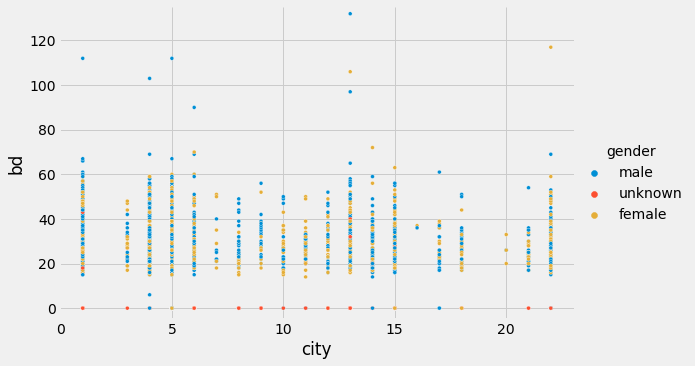

In [31]:
import seaborn as sns
sns.relplot(data=members, x='city', y='bd', hue='gender', aspect=1.6, s=15)
plt.ylim(-5, 135)
plt.show();

#### members.registered_via

In [32]:
print(f"`registered_via` has {len(members['registered_via'].unique())} levels:")

`registered_via` has 14 levels:


In [33]:
pd.crosstab(index=members['registered_via'], columns='count')

col_0,count
registered_via,
1,1
2,2
3,1648
4,2710
5,2
6,1
7,798
8,3
9,1451


In [34]:
top5(members,'registered_via',Nm)

registered_via	%
2710	40.7
1648	24.8
1451	21.8
798	12.0
31	0.5


#### members.registration_init_time

Earliest member registration:	 2004-03-27
Latest member registration:	 2017-04-29


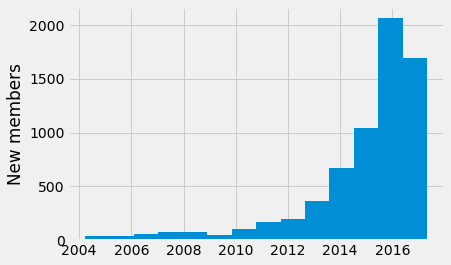

In [35]:
print("Earliest member registration:\t", np.min(members.registration_init_time).strftime('%Y-%m-%d'))
print("Latest member registration:\t", np.max(members.registration_init_time).strftime('%Y-%m-%d'))
plt.hist(members.registration_init_time, bins=2017-2004+1)
plt.ylabel('New members');

#### 2.4.2 transactions.csv

In [36]:
trans.shape

(22940, 9)

In [37]:
trans.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,5F7G3pHKf5ijGQpoKuko0G7Jm3Bde6ktfPKBZySWoDI=,41,30,99,99,1,2017-02-10,2017-03-10,0
1,DQMPoCSc6EB39ytgnKCRsUIZnR6ZWSrHeDmX7nbxAKs=,41,30,149,149,1,2016-02-01,2016-03-02,0
2,Lrais3nsgqYwpfpSoyK3fHuPutf6cloTI5T5dQfs4lA=,38,30,149,149,0,2016-02-23,2016-04-23,0
3,ZPOjgxQw1/J7v5xgBJTCLXWuwq5Xmk33nO6AoUO1+mY=,41,30,149,119,1,2015-09-06,2016-08-01,0
4,MvR23u4bIiWM+U+VE1Mvw3qqdj/0Ixs1sf7avavjhRs=,38,30,149,149,0,2016-10-28,2016-11-27,0


#### trans.msno

In [38]:
Ntm = nu(trans.msno)
print("No. of members with available transaction data:", Ntm)
print(f"Proportion of members with available transaction data: {round(len(trans.msno.unique())/Nm*100,1)}%")

No. of members with available transaction data: 2434
Proportion of members with available transaction data: 36.6%


<font color=red><b>Q2 Discard all members with no transaction and churn information?</b></font>

#### trans.payment_method_id

In [39]:
trans.payment_method_id.describe()

count    22940.000000
mean        38.903575
std          3.548366
min          8.000000
25%         38.000000
50%         41.000000
75%         41.000000
max         41.000000
Name: payment_method_id, dtype: float64

In [40]:
print("Levels of payment method:", np.sort(trans.payment_method_id.unique()))

Levels of payment method: [ 8 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34
 35 36 37 38 39 40 41]


In [41]:
vc_pm = trans.payment_method_id.value_counts()
vc_pm.head()

41    11983
40     2508
38     1851
39     1659
37     1193
Name: payment_method_id, dtype: int64

In [42]:
Nt = trans.shape[0]
print("No. of transactions:", Nt)
top5(trans,'payment_method_id',Nt)

No. of transactions: 22940
payment_method_id	%
11983	52.2
2508	10.9
1851	8.1
1659	7.2
1193	5.2


Looking at one of the member's data, we see only one payment method:

In [43]:
trans.loc[trans.msno=='5F7G3pHKf5ijGQpoKuko0G7Jm3Bde6ktfPKBZySWoDI=']

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,5F7G3pHKf5ijGQpoKuko0G7Jm3Bde6ktfPKBZySWoDI=,41,30,99,99,1,2017-02-10,2017-03-10,0
1020,5F7G3pHKf5ijGQpoKuko0G7Jm3Bde6ktfPKBZySWoDI=,41,30,99,99,1,2015-11-10,2015-12-10,0
4151,5F7G3pHKf5ijGQpoKuko0G7Jm3Bde6ktfPKBZySWoDI=,41,30,99,99,1,2015-10-11,2015-11-10,0
4735,5F7G3pHKf5ijGQpoKuko0G7Jm3Bde6ktfPKBZySWoDI=,41,30,99,99,1,2016-01-10,2016-02-10,0
7267,5F7G3pHKf5ijGQpoKuko0G7Jm3Bde6ktfPKBZySWoDI=,41,30,99,99,1,2016-02-10,2016-03-10,0
8705,5F7G3pHKf5ijGQpoKuko0G7Jm3Bde6ktfPKBZySWoDI=,41,30,99,99,1,2016-08-10,2016-09-10,0
9597,5F7G3pHKf5ijGQpoKuko0G7Jm3Bde6ktfPKBZySWoDI=,41,30,99,99,1,2016-05-10,2016-06-10,0
10303,5F7G3pHKf5ijGQpoKuko0G7Jm3Bde6ktfPKBZySWoDI=,41,30,99,99,1,2016-07-10,2016-08-10,0
10909,5F7G3pHKf5ijGQpoKuko0G7Jm3Bde6ktfPKBZySWoDI=,41,30,99,99,1,2016-09-10,2016-10-10,0
11228,5F7G3pHKf5ijGQpoKuko0G7Jm3Bde6ktfPKBZySWoDI=,41,30,99,99,1,2016-10-10,2016-11-10,0


Does each member use only one payment method? No, from 1 to 5 payment methods were used by a member.

In [44]:
uv_pm = pd.pivot_table(trans, index='msno', values='payment_method_id', aggfunc=nu) # how many payment methods were used by each member
uv_pm.rename(columns = {'payment_method_id':'n_payment_methods'}, inplace = True)
uv_pm.head()

,n_payment_methods
msno,
++bK0FRJecXCogqXdjtO2Kyb3jq7uLM7qThTk+nN8tE=,1
+0STIeZNRNVHd561CaWnwJVvjaV+FLW+pAYK6sfmKXQ=,2
+8BSu/tg0Y7DIY+q1S1mgHnFSQkRvb+/QVdwE7KMFU0=,1
+95t/v4J6t8a3D3ZhpsUDCL7reDGJKsDPPkRPVlGOZ4=,1
+9Q0UzM+XCIzH1BNZPFbFzvwt6QdIYd/DLn6nMt0TIU=,1


In [45]:
uv_pm.n_payment_methods.sort_values(ascending=False)

msno
Tq1aYXKTql7jPtgRCiyQ6xuMTiluycrRKG7HFl5hnSs=    5
XDvqZ7KtY0J80pbyJnqVRpI7ZFgYu9D6zYWKQImrXjA=    5
fH1Zz4lUeEsxX30G/V76NqBoHOS0vuGSFN9HjKWnCpU=    4
zfwHJ6LRTVfIhmwU6dm18f4nQhNJklA1dc/YM6tYmJE=    4
PwLdVzv98EqPz0uKoeFEKGh05Dsgldov3wlozEtN+SM=    4
                                               ..
LIzQJvG7np60EDFEiZ7FDueKgMTATASdfBhBfi1Kx1o=    1
LHjrZBjEa174FOZ4M7OirVlL8yvazN/609+xK4LjDp8=    1
LH9NrH31zn/i6p8Wihu9yO5gd0ZMLptskYYqFvXoR+o=    1
LFa6kalNBTzKg8ixv+yIC1m3KDJSXKOXxuxhhSPgcDI=    1
V91x6HpYEohG5ZdV7sk26ko2NcE/EWQ6vwI9YCGfr0k=    1
Name: n_payment_methods, Length: 2434, dtype: int64

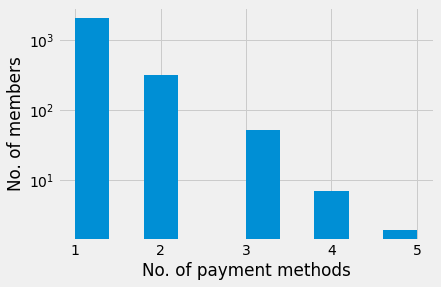

In [46]:
plt.semilogy();
uv_pm.n_payment_methods.hist();
plt.xlabel('No. of payment methods');
plt.ylabel('No. of members');

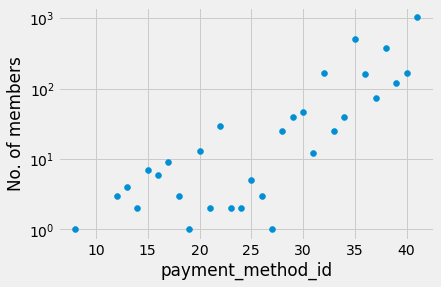

In [47]:
uv_mem = pd.pivot_table(trans, index='payment_method_id', values='msno', aggfunc=nu) # how many members used each payment method
uv_mem.rename(columns = {'msno':'n_members'}, inplace = True)
plt.semilogy()
plt.scatter(uv_mem.index, uv_mem.n_members);
plt.xlabel("payment_method_id");
plt.ylabel("No. of members");

In [48]:
print(np.sort(trans.payment_plan_days.unique()))

[  0   1   2   7  10  14  30  31  35  60  80  90 100 120 180 195 200 240
 270 360 365 395 400 410 415 450]


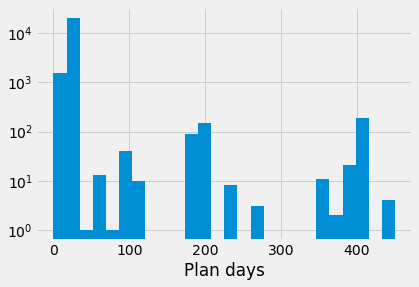

In [49]:
plt.semilogy();
trans.payment_plan_days.hist(bins=nu(trans.payment_plan_days));
plt.xlabel('Plan days');

In [50]:
print(f"Of payment_plan_days == 0, only {round(100*trans.loc[trans.payment_plan_days == 0].is_cancel.sum()/trans.loc[trans.payment_plan_days == 0].is_cancel.shape[0],2)}% transactions were cancellations.")

Of payment_plan_days == 0, only 3.25% transactions were cancellations.


In [51]:
# how many different plan days each member had
uv_pd = pd.pivot_table(trans, index='msno', values='payment_plan_days', aggfunc=nu)
uv_pd.rename(columns = {'payment_plan_days':'n_payment_plan_days'}, inplace = True)
uv_pd.head()

,n_payment_plan_days
msno,
++bK0FRJecXCogqXdjtO2Kyb3jq7uLM7qThTk+nN8tE=,1
+0STIeZNRNVHd561CaWnwJVvjaV+FLW+pAYK6sfmKXQ=,2
+8BSu/tg0Y7DIY+q1S1mgHnFSQkRvb+/QVdwE7KMFU0=,2
+95t/v4J6t8a3D3ZhpsUDCL7reDGJKsDPPkRPVlGOZ4=,1
+9Q0UzM+XCIzH1BNZPFbFzvwt6QdIYd/DLn6nMt0TIU=,2


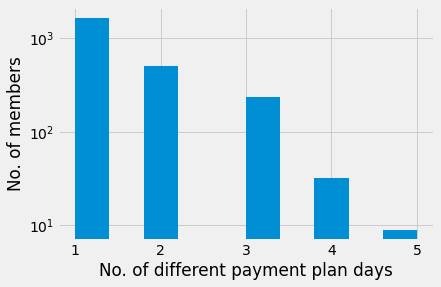

In [52]:
plt.semilogy();
uv_pd.n_payment_plan_days.hist();
plt.xlabel('No. of different payment plan days');
plt.ylabel('No. of members');

#### trans.plan_list_price

In [53]:
nu(trans.plan_list_price)

31

In [54]:
print("Levels of plan list price:", np.sort(trans.plan_list_price.unique()))

Levels of plan list price: [   0   10   35   50   99  100  119  120  129  134  149  150  180  298
  300  400  447  477  480  500  536  600  699  799  894  930 1200 1299
 1599 1788 2000]


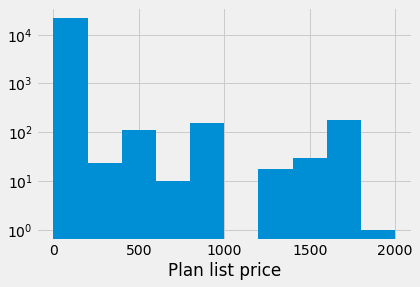

In [55]:
plt.semilogy();
trans.plan_list_price.hist();
plt.xlabel('Plan list price');

#### trans.actual_amount_paid -> discount

In [56]:
nu(trans.actual_amount_paid)

31

In [57]:
print("Levels of plan list price:", np.sort(trans.actual_amount_paid.unique()))

Levels of plan list price: [   0   10   35   50   99  100  119  120  129  134  149  150  180  298
  300  400  447  477  480  500  536  600  699  799  894  930 1200 1299
 1599 1788 2000]


In [58]:
print(f"`actual_amount_paid > plan_list_price` only when `plan_list_price` == {trans.loc[trans.actual_amount_paid > trans.plan_list_price].plan_list_price.unique()}")

`actual_amount_paid > plan_list_price` only when `plan_list_price` == [0]


In [59]:
trans['discount'] = trans.plan_list_price - trans.actual_amount_paid
print(f"Discount levels: {np.sort(trans.loc[trans.discount > 0].discount.unique())}")

Discount levels: [ 20  30 120 149 180]


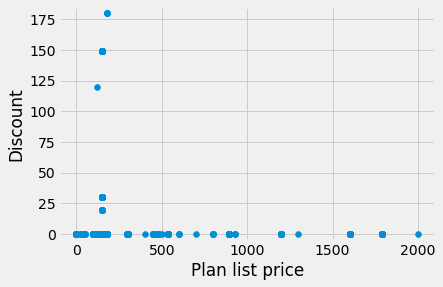

In [60]:
plt.scatter(trans.plan_list_price, trans.discount);
plt.ylim([-5,185]);
plt.xlabel('Plan list price');
plt.ylabel('Discount');

#### is_auto_renew

In [61]:
print(f"Proportion of auto renew transactions: {round(100*trans.is_auto_renew.sum()/Nt,1)}%")

Proportion of auto renew transactions: 85.1%


#### transaction_date

In [62]:
print(np.min(trans.transaction_date).strftime('%Y-%m-%d'))
print(np.max(trans.transaction_date).strftime('%Y-%m-%d'))

2015-01-01
2017-03-31


There is an overall growth in the number of transactions.

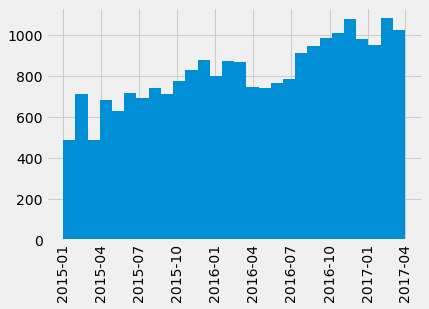

In [63]:
plt.xticks(rotation=90)
trans.transaction_date.hist(bins=2*12+4);

#### membership_expire_date

In [64]:
nu(trans.membership_expire_date)

1022

Some values are invalid (before earliest membership subscription):

In [65]:
np.min(trans.membership_expire_date).strftime('%Y-%m-%d')

'1970-01-01'

some other are in the future,

In [66]:
np.max(trans.membership_expire_date).strftime('%Y-%m-%d')

'2018-06-10'

In [67]:
def md(tn):
    '''Membership duration (days) for transaction number tn'''
    return trans.membership_expire_date[tn] - members.loc[members.msno == trans.msno[tn]].registration_init_time

In [68]:
md(0)

1421   2360 days
Name: registration_init_time, dtype: timedelta64[ns]

#### is_cancel

In [69]:
print(f"Proportion of cancellation transactions: {round(100*trans.is_cancel.sum()/Nt,2)}%")

Proportion of cancellation transactions: 3.95%


#### 2.4.3 logs.csv

In [70]:
logs.head()

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,6+/V1NwBbqjBOCvRSDueeJZ58F4DY7h7fG6fSZtHaAE=,2017-03-04,29,28,18,11,111,79,34727.142
1,E2aBGFTKR6jzp+1knh7JOOF39gLuu+CoZMWaAL/DA0M=,2017-03-27,1,0,2,0,184,173,33408.719
2,g7exJzakJlHXwzUydnShY5w24WXSwJyS6QqgoFeyr7g=,2017-03-15,0,0,0,0,21,21,4951.000
3,X+i9OmM3P42cETt5gPkOnz8vXGViQL5/M/NMiMQ+Olc=,2017-03-13,3,1,0,0,33,27,8755.599
4,tbl8blAVl6j4A8zW1Gnyg78Hc0LAQzzcYesmzgJ7ofs=,2017-03-27,6,5,0,0,2,6,1035.853


#### logs.msno

In [71]:
Nlm = nu(logs.msno)
print("No. of members with available logs data:", Nlm)
print(f"Proportion of members with available logs data: {round(len(logs.msno.unique())/Nlm*100,1)}%")

No. of members with available logs data: 5214
Proportion of members with available logs data: 100.0%


#### logs.date

In [72]:
print("Earliest:",np.min(logs.date).strftime('%Y-%m-%d'))
print("Latest:",np.max(logs.date).strftime('%Y-%m-%d'))

Earliest: 2015-01-01
Latest: 2017-03-31


In [73]:
logs.describe()

,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
count,424252.000000,424252.000000,424252.000000,424252.000000,424252.000000,424252.000000,4.242520e+05
mean,6.276480,1.571901,0.978503,1.044558,31.394426,29.348618,8.110696e+03
std,12.853579,3.900916,2.064198,2.459123,46.805506,33.006411,1.166276e+04
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000e+00
25%,0.000000,0.000000,0.000000,0.000000,6.000000,8.000000,1.862119e+03
50%,2.000000,1.000000,0.000000,0.000000,16.000000,18.000000,4.546765e+03
75%,7.000000,2.000000,1.000000,1.000000,38.000000,39.000000,1.006348e+04
max,937.000000,257.000000,204.000000,201.000000,4376.000000,2944.000000,2.763295e+06


#### logs.num_25
Number of songs listened upto 25% of their duration.

In [74]:
print("Unique songs:",nu(logs.num_25))

Unique songs: 288


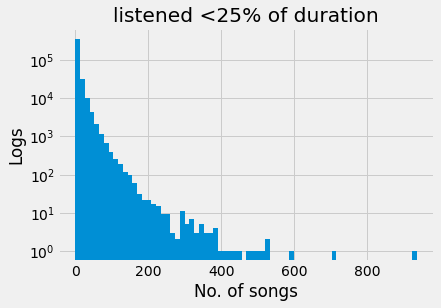

In [75]:
plt.semilogy();
logs.num_25.hist(bins=nu(logs.num_25)//4);
plt.xlabel('No. of songs');
plt.ylabel('Logs');
plt.title('listened <25% of duration');

#### logs.num_50
Number of songs listened 25-50% of their duration.

In [76]:
print("Unique songs:",nu(logs.num_50))

Unique songs: 137


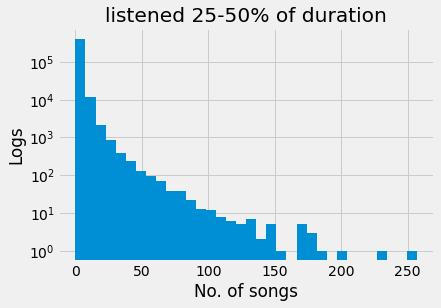

In [77]:
plt.semilogy();
logs.num_50.hist(bins=nu(logs.num_50)//4);
plt.xlabel('No. of songs');
plt.ylabel('Logs');
plt.title('listened 25-50% of duration');

#### logs.num_75
Number of songs listened 50-75% of their duration.

In [78]:
print("Unique songs:",nu(logs.num_75))

Unique songs: 83


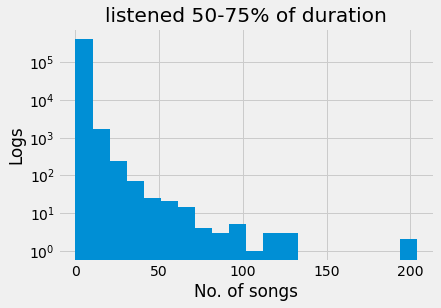

In [79]:
plt.semilogy();
logs.num_75.hist(bins=nu(logs.num_75)//4);
plt.xlabel('No. of songs');
plt.ylabel('Logs');
plt.title('listened 50-75% of duration');

#### logs.num_985
Number of songs listened 75-98.5% of their duration.

In [80]:
print("Unique songs:",nu(logs.num_985))

Unique songs: 109


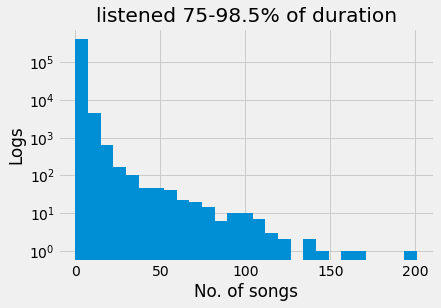

In [81]:
plt.semilogy();
logs.num_985.hist(bins=nu(logs.num_985)//4);
plt.xlabel('No. of songs');
plt.ylabel('Logs');
plt.title('listened 75-98.5% of duration');

#### logs.num_100
Number of songs listened 98.5-100% of their duration.

In [82]:
print("Unique songs:",nu(logs.num_100))

Unique songs: 734


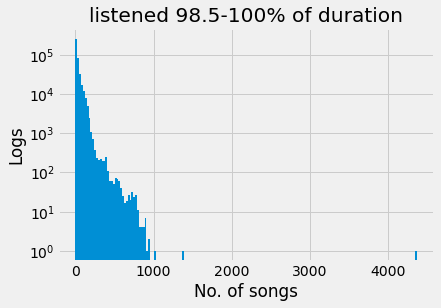

In [83]:
plt.semilogy();
logs.num_100.hist(bins=nu(logs.num_100)//4);
plt.xlabel('No. of songs');
plt.ylabel('Logs');
plt.title('listened 98.5-100% of duration');

Distributions of the number of logs with listening percentage are similar upto 75% of the duration of a song.

#### logs.num_unq

In [84]:
print("Unique songs:",nu(logs.num_unq))

Unique songs: 386


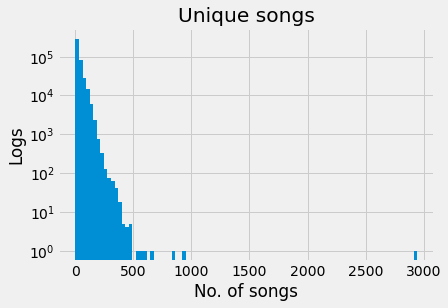

In [85]:
plt.semilogy();
logs.num_unq.hist(bins=nu(logs.num_unq)//4);
plt.xlabel('No. of songs');
plt.ylabel('Logs');
plt.title('Unique songs');

#### logs.total_secs

In [86]:
logs[logs.total_secs == 0] # missing values

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
20253,nwlTp8aUeXYNlzdEhBKNoii6BTLFTtI+Q10igaGfuqk=,2015-10-02,15,3,1,0,12,30,0.0
24207,8hfMRQH9/Jp5C6N43Hnqliwc0VDbsSDrgDRfeMAaeBQ=,2015-07-21,2,1,0,0,19,21,0.0
30733,5o/oARKZiImsG8fsFYTBV34WB5l54Mn1Rof6Ci8OB7Q=,2015-05-04,6,1,3,2,28,25,0.0
37881,8hfMRQH9/Jp5C6N43Hnqliwc0VDbsSDrgDRfeMAaeBQ=,2015-09-13,0,0,0,0,68,68,0.0
39979,efPfmkS46YQhIwGJPD0amNG+CGds/8DNH5eDQvUjOAU=,2015-08-19,1,1,2,0,17,21,0.0
52445,5CInFKkcBo/UxkObN6mzrj/KOKPXiJ6Rg2SmVCI9T3k=,2015-06-23,5,1,0,1,72,69,0.0
56687,nwlTp8aUeXYNlzdEhBKNoii6BTLFTtI+Q10igaGfuqk=,2015-06-19,5,4,2,2,29,39,0.0
62286,5o/oARKZiImsG8fsFYTBV34WB5l54Mn1Rof6Ci8OB7Q=,2015-05-08,3,2,6,1,41,35,0.0
70169,8hfMRQH9/Jp5C6N43Hnqliwc0VDbsSDrgDRfeMAaeBQ=,2015-06-01,1,0,0,0,23,23,0.0
70170,8hfMRQH9/Jp5C6N43Hnqliwc0VDbsSDrgDRfeMAaeBQ=,2015-07-28,6,1,2,0,15,24,0.0


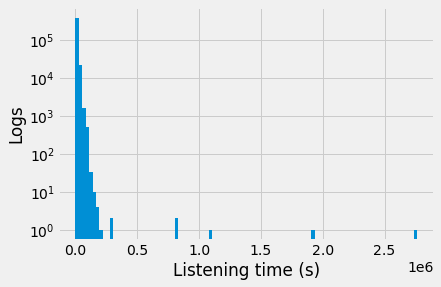

In [87]:
plt.semilogy();
logs[logs.total_secs > 0].total_secs.hist(bins=100);
plt.xlabel('Listening time (s)');
plt.ylabel('Logs');

In [88]:
logs[(0 < logs.total_secs) & (logs.total_secs < 1)].total_secs.describe()

count    134.000000
mean       0.520963
std        0.283591
min        0.001000
25%        0.292250
50%        0.515000
75%        0.758000
max        0.995000
Name: total_secs, dtype: float64

<font color=red><b>Q3 At which point should I merge 3 datafiles?</b></font>

### 2.5 Clean data: fix times, remove useless, replace missing
#### 2.5.1 Fix errors in dates
#### members.registration_init_time

The earliest event is initial registration: members['registration_init_time'] must always be before or same as trans['transaction_date'].

In [89]:
members['registration_init_time'].head()

0   2014-11-04
1   2007-02-11
2   2013-02-08
3   2015-02-01
4   2015-02-12
Name: registration_init_time, dtype: datetime64[ns]

In [92]:
# Does it mistakenly happen that `registration_init_time` is later than `transaction_date`?
n_violations=0
for i in range(Nt):
    tr = trans.iloc[i]
    member_id = tr['msno']
    members_row = members.loc[members['msno']==member_id, 'registration_init_time']
    if len(members_row) > 0: # some member_id's are in trans.csv, but not in members.csv
        registration_init_time = members_row.squeeze()
        if len(members.loc[members['msno']==member_id, 'registration_init_time'])>1:
            print(i);
            break;
        transaction_date = tr['transaction_date']
        if (registration_init_time > transaction_date):
            print(i)
            n_violations=n_violations+1
n_violations

0

No violations of this rule: indeed, `registration_init_time` is the same or earlier than `transaction_date`. Now compare the former with `membership_expire_date`.

In [100]:
# Check inconsistency in dates
print('Records where `registration_init_time` is later than `membership_expire_date`')
n_violations=0
for i in range(Nt):
    tr = trans.iloc[i]
    member_id = tr['msno']
    members_row = members.loc[members['msno']==member_id, 'registration_init_time']
    if len(members_row) > 0: # some member_id's are in trans.csv, but not in members.csv
        registration_init_time = members_row.squeeze()
        if len(members.loc[members['msno']==member_id, 'registration_init_time'])>1:
            print(i);
            break;
        if (registration_init_time > tr['membership_expire_date']):
            print(i)
            n_violations=n_violations+1
n_violations

Records where `registration_init_time` is later than `membership_expire_date`


0

In both violations, `membership_expire_date = 1970-01-01`:

In [94]:
trans.iloc[1860] # Example of violation: `membership_expire_date = 1970-01-01`
#trans.iloc[17032]

msno                      PwLdVzv98EqPz0uKoeFEKGh05Dsgldov3wlozEtN+SM=
payment_method_id                                                   17
payment_plan_days                                                   60
plan_list_price                                                      0
actual_amount_paid                                                   0
is_auto_renew                                                        0
transaction_date                                   2017-02-01 00:00:00
membership_expire_date                             1970-01-01 00:00:00
is_cancel                                                            0
discount                                                             0
Name: 1860, dtype: object

<font color=red><b>Q4 Should I replace `membership_expire_date` with `transaction_date` or remove these 2 transactions?<br>
    I prefer to replace.</b></font>

In [95]:
# Find rows with invalid `membership_expire_date`
trans.loc[trans['membership_expire_date']=='1970-01-01']

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,discount
1860,PwLdVzv98EqPz0uKoeFEKGh05Dsgldov3wlozEtN+SM=,17,60,0,0,0,2017-02-01,1970-01-01,0,0
17032,5xbdjKsic/Epqj8hGz1TmMBHpyQdxlVF1PUmPElQMU0=,17,120,0,0,0,2017-02-03,1970-01-01,0,0
18535,/F+d7seAF3MQv6bNGSFU+8BAxzI7BZLjq+XJpZgPSXA=,24,30,149,149,1,2015-02-06,1970-01-01,1,0


In [96]:
from datetime import date, timedelta

In [97]:
def fix_membership_expire_date(df,idx):
    '''Fix membership_expire_date in dataframe df, row no. idx'''
    tr = df.iloc[i] # row no. idx in df
    med = tr['membership_expire_date'].strftime('%Y-%m-%d') #membership_expire_date
    if (med == '1970-01-01') or (tr['transaction_date'] >= tr['membership_expire_date']): # then fix it
        Date = tr['transaction_date'].date() #Timestamp => datetime.date
        med = Date + timedelta(days=int(tr.payment_plan_days)) # transaction date + payment plan days
        med = pd.Timestamp(med)
        df.loc[i,'membership_expire_date'] = med
    return med

In [98]:
idx=[1860,17032,18535]
for i in idx:
    fix_membership_expire_date(trans,i)

Timestamp('2017-04-02 00:00:00')

Timestamp('2017-06-03 00:00:00')

Timestamp('2015-03-08 00:00:00')

Now indeed `registration_init_time` <= `membership_expire_date`.

#### trans.transaction_date <= trans.membership_expire_date

In [101]:
# Count and fix violations
n_violations=0
for i in range(Nt):
    tr = trans.iloc[i]
    if (tr['transaction_date'] >= tr['membership_expire_date']):
        print(i)
        n_violations=n_violations+1
        fix_membership_expire_date(trans,i)
n_violations

3811


Timestamp('2015-05-06 00:00:00')

6637


Timestamp('2015-05-14 00:00:00')

6875


Timestamp('2015-04-25 00:00:00')

7286


Timestamp('2015-05-08 00:00:00')

7868


Timestamp('2015-04-30 00:00:00')

9642


Timestamp('2015-05-10 00:00:00')

10013


Timestamp('2015-05-14 00:00:00')

11307


Timestamp('2015-04-28 00:00:00')

11419


Timestamp('2015-05-09 00:00:00')

14639


Timestamp('2015-05-09 00:00:00')

17990


Timestamp('2015-04-28 00:00:00')

18062


Timestamp('2015-05-13 00:00:00')

19058


Timestamp('2015-05-05 00:00:00')

20254


Timestamp('2015-05-04 00:00:00')

14

There are 608 violations of `trans.transaction_date < trans.membership_expire_date`.

In [102]:
# Count remaining violations
n_violations=0
for i in range(Nt):
    tr = trans.iloc[i]
    if (tr['transaction_date'] >= tr['membership_expire_date']):
        n_violations=n_violations+1
        #fix_membership_expire_date(trans,i)
        print(i, tr.is_cancel, tr.membership_expire_date - tr.transaction_date)
n_violations

3811 1 0 days 00:00:00
6637 1 0 days 00:00:00
6875 1 0 days 00:00:00
7286 1 0 days 00:00:00
7868 1 0 days 00:00:00
9642 1 0 days 00:00:00
10013 1 0 days 00:00:00
11307 0 0 days 00:00:00
11419 1 0 days 00:00:00
14639 1 0 days 00:00:00
17990 1 0 days 00:00:00
18062 1 0 days 00:00:00
19058 1 0 days 00:00:00
20254 1 0 days 00:00:00


14

In all 14 cases, `membership_expire_date` coincides with `transaction_date` due to `payment_plan_days==0`, which amost always is accompanied by `is_cancel==1` (except for row 11307, for which immediate expiration is still due to `payment_plan_days==0`, and there is no future transactions for this member. Therefore, `is_cancel` should probably be 1 here.)

In [103]:
trans.iloc[11307]

msno                      4X5qK8pnV2YMJJBahyDoXPyj0g4PcV3CD2V6/3n/L8I=
payment_method_id                                                   24
payment_plan_days                                                    0
plan_list_price                                                      0
actual_amount_paid                                                 149
is_auto_renew                                                        1
transaction_date                                   2015-04-28 00:00:00
membership_expire_date                             2015-04-28 00:00:00
is_cancel                                                            0
discount                                                          -149
Name: 11307, dtype: object

In [104]:
# Save `trans` with fixed times
if not Path("./data/transactions.csv").is_file():
    trans.to_csv("./data/transactions.csv")


#### 2.5.2 Merge `members` and `trans`
There are many members without transaction information, which makes it impossible to get churn labels. To remove data for such members, we merge `members.csv` and `transactions.csv` by retaining only members present in `transactions.csv`.

In [105]:
mt = members.merge(trans, how='right', on='msno')
mt.shape

(22940, 15)

`members.csv` is no longer needed.

In [106]:
mt = mt.sort_values(by=['registration_init_time','msno','transaction_date']) # chronological sorting
mt.head(100)

,msno,city,bd,gender,registered_via,registration_init_time,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,discount
18506,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,13.0,28.0,female,9.0,2004-03-27,32,410,1788,1788,0,2015-06-16,2016-07-30,0,0
6085,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,13.0,28.0,female,9.0,2004-03-27,38,30,149,149,0,2016-08-01,2016-08-31,0,0
16905,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,13.0,28.0,female,9.0,2004-03-27,38,30,149,149,0,2016-09-13,2016-10-13,0,0
21590,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,13.0,28.0,female,9.0,2004-03-27,32,415,1599,1599,0,2016-10-23,2017-12-12,0,0
13735,9N+q58Vl33+QW6zHwivroNlgJw88g9ghwX/ke+OhgtM=,15.0,0.0,female,9.0,2004-03-27,34,0,0,149,1,2015-03-31,2015-04-30,0,-149
7492,9N+q58Vl33+QW6zHwivroNlgJw88g9ghwX/ke+OhgtM=,15.0,0.0,female,9.0,2004-03-27,34,0,0,149,1,2015-06-30,2015-07-31,0,-149
11406,9N+q58Vl33+QW6zHwivroNlgJw88g9ghwX/ke+OhgtM=,15.0,0.0,female,9.0,2004-03-27,34,0,0,149,1,2015-07-31,2015-08-31,0,-149
639,9N+q58Vl33+QW6zHwivroNlgJw88g9ghwX/ke+OhgtM=,15.0,0.0,female,9.0,2004-03-27,34,0,0,149,1,2015-08-31,2015-09-30,0,-149
4325,9N+q58Vl33+QW6zHwivroNlgJw88g9ghwX/ke+OhgtM=,15.0,0.0,female,9.0,2004-03-27,34,0,0,149,1,2015-09-30,2015-10-31,0,-149
17631,9N+q58Vl33+QW6zHwivroNlgJw88g9ghwX/ke+OhgtM=,15.0,0.0,female,9.0,2004-03-27,34,0,0,149,1,2015-10-31,2015-11-30,0,-149


In [107]:
mt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22940 entries, 18506 to 21900
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   msno                    22940 non-null  object        
 1   city                    19944 non-null  float64       
 2   bd                      19944 non-null  float64       
 3   gender                  19944 non-null  object        
 4   registered_via          19944 non-null  float64       
 5   registration_init_time  19944 non-null  datetime64[ns]
 6   payment_method_id       22940 non-null  int64         
 7   payment_plan_days       22940 non-null  int64         
 8   plan_list_price         22940 non-null  int64         
 9   actual_amount_paid      22940 non-null  int64         
 10  is_auto_renew           22940 non-null  int64         
 11  transaction_date        22940 non-null  datetime64[ns]
 12  membership_expire_date  22940 non-null  da

However, 466 members in `trans` are not in `members`,

In [108]:
nu( mt.loc[mt['registration_init_time'].isnull(), 'msno'] )

466

which leads to missing values for the membership features in 2996 corresponding `logs` records in the merged dataframe:

In [109]:
mt.tail(2)

,msno,city,bd,gender,registered_via,registration_init_time,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,discount
6412,zw/r9AbH/cAbTuZj91fb6na3+7xHz4yo1452QblSaUA=,NaN,NaN,NaN,NaN,NaT,41,30,99,99,1,2017-02-19,2017-03-19,0,0
21900,zw/r9AbH/cAbTuZj91fb6na3+7xHz4yo1452QblSaUA=,NaN,NaN,NaN,NaN,NaT,41,30,99,99,1,2017-03-19,2017-04-19,0,0


We need to replace the missing values, arising from member ID's in `transactions.csv` that are absent in `members.csv`.

Since the minimum value of `city` is 1,

In [110]:
np.min(members.city)

1

we can use 0 to encode missing city. The minimum value of age is 0,

In [111]:
np.min(members.bd)

0

which indicates the missing value, so let's use 0 for the missing age. For gender, we use 'unknown'. Minimal `registered_via` is 1,

In [112]:
np.min(members.registered_via.unique())

1

so let's use 0 for missing values.

To fix missing `registration_init_time` values, note that it should be no later than the `earliest transaction_date` for a given member. We could take the mean `registration_init_time` of '2014-12-03',

In [113]:
registration_init_time_mean = np.mean(members.registration_init_time) # mean initial registration time
registration_init_time_mean = pd.Timestamp(registration_init_time_mean.date()) # extract date
registration_init_time_mean

Timestamp('2014-12-03 00:00:00')

since it is earlier than all relevant `transaction_date` values,

In [114]:
mt_null_transaction_dates = mt.loc[mt['registration_init_time'].isnull(), ['transaction_date']]
mt_null_transaction_dates.shape

(2996, 1)

In [115]:
print("No. of records with `transaction_date` before mean `registration_init_time`:")
np.sum(mt_null_transaction_dates <= registration_init_time_mean).iloc[0]

No. of records with `transaction_date` before mean `registration_init_time`:


0

However, it seems more reasonable to subtract the average interval between initial registration and first transaction from the first transaction date. Let's find number of days between `registration_init_time` and `first_transaction_date`.

#### first_transaction_date, reg_to_trans_days

In [116]:
first_transaction_date = pd.DataFrame(columns=['msno', 'reg_to_trans_days', 'first_transaction_date'])
for member_id in mt['msno'].unique():
    member_records = mt.loc[mt['msno'] == member_id, ['registration_init_time','transaction_date']]
    registration_init_time = member_records['registration_init_time'].iloc[0]
    #print('registration_init_time:',registration_init_time.strftime('%Y-%m-%d'))
    earliest_transaction_date = np.min(member_records['transaction_date'])
    #print('earliest_transaction_date:',earliest_transaction_date.strftime('%Y-%m-%d'))
    reg_to_trans_days = (earliest_transaction_date - registration_init_time).days
    # add record
    first_transaction_date.loc[len(first_transaction_date.index)] = [member_id, reg_to_trans_days, earliest_transaction_date]
first_transaction_date.head()

,msno,reg_to_trans_days,first_transaction_date
0,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,4098,2015-06-16
1,9N+q58Vl33+QW6zHwivroNlgJw88g9ghwX/ke+OhgtM=,4021,2015-03-31
2,9rzbu7TiCDnfkSXSx9O0DZhmEBSncZ0VBmS2l1b5kg8=,3942,2015-01-11
3,/G/XFknHm94YVoCefhCyvnB9mAFM0rUSMqSNA/n+jTg=,4010,2015-03-31
4,BvmNMrNw/X4PB8ueWGZ0JswZoUAGGpMZET03F+rkmTI=,4248,2016-01-04


In [120]:
first_transaction_date.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2434 entries, 0 to 2433
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   msno                    2434 non-null   object        
 1   reg_to_trans_days       1968 non-null   object        
 2   first_transaction_date  2434 non-null   datetime64[ns]
dtypes: datetime64[ns](1), object(2)
memory usage: 76.1+ KB


Where `registration_init_time` was missing, the `reg_to_trans_days` is missing:

In [121]:
first_transaction_date.tail(2)

,msno,reg_to_trans_days,first_transaction_date
2432,zje425fKTQ7EAtsSAKFrK9BX33hb7rOBi7ktnIdX7yU=,NaN,2016-08-01
2433,zw/r9AbH/cAbTuZj91fb6na3+7xHz4yo1452QblSaUA=,NaN,2016-12-20


In [122]:
reg_to_trans_days_mean = round(np.mean(first_transaction_date['reg_to_trans_days']))
print('Mean interval between initial registration and first transaction:',reg_to_trans_days_mean,'days')

Mean interval between initial registration and first transaction: 726 days


We can replace the missing `reg_to_trans_days` by `reg_to_trans_days_mean`:

In [123]:
first_transaction_date = first_transaction_date.fillna(value={'reg_to_trans_days':reg_to_trans_days_mean})
first_transaction_date.tail(2)

,msno,reg_to_trans_days,first_transaction_date
2432,zje425fKTQ7EAtsSAKFrK9BX33hb7rOBi7ktnIdX7yU=,726,2016-08-01
2433,zw/r9AbH/cAbTuZj91fb6na3+7xHz4yo1452QblSaUA=,726,2016-12-20


In [124]:
# Replace all missing values in `mt`
registration_init_time_fixed = list([])
for i in range(mt.shape[0]):
    mt_record = mt.iloc[i]
    if mt_record.notnull()['registration_init_time']: # not missing
        registration_init_time_fixed.append(mt_record['registration_init_time'])
    else:
        earliest_transaction_date = first_transaction_date.loc[first_transaction_date['msno'] ==\
                                            mt_record['msno']]['first_transaction_date'].iloc[0]
        registration_init_time = earliest_transaction_date - pd.Timedelta(reg_to_trans_days_mean*1e9*3600*24)
        registration_init_time_fixed.append(registration_init_time)
mt['registration_init_time'] = registration_init_time_fixed
mt = mt.fillna(value={'city':0, 'bd':0, 'gender':'unknown', 'registered_via':0})
mt.tail()

,msno,city,bd,gender,registered_via,registration_init_time,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,discount
7765,zje425fKTQ7EAtsSAKFrK9BX33hb7rOBi7ktnIdX7yU=,0.0,0.0,unknown,0.0,2014-08-06,41,30,149,0,1,2016-08-30,2016-09-29,1,149
472,zw/r9AbH/cAbTuZj91fb6na3+7xHz4yo1452QblSaUA=,0.0,0.0,unknown,0.0,2014-12-25,41,30,99,99,1,2016-12-20,2017-01-19,0,0
4054,zw/r9AbH/cAbTuZj91fb6na3+7xHz4yo1452QblSaUA=,0.0,0.0,unknown,0.0,2014-12-25,41,30,99,99,1,2017-01-19,2017-02-19,0,0
6412,zw/r9AbH/cAbTuZj91fb6na3+7xHz4yo1452QblSaUA=,0.0,0.0,unknown,0.0,2014-12-25,41,30,99,99,1,2017-02-19,2017-03-19,0,0
21900,zw/r9AbH/cAbTuZj91fb6na3+7xHz4yo1452QblSaUA=,0.0,0.0,unknown,0.0,2014-12-25,41,30,99,99,1,2017-03-19,2017-04-19,0,0


In [117]:
mt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22940 entries, 21363 to 7357
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   msno                    22940 non-null  object        
 1   city                    22940 non-null  float64       
 2   bd                      22940 non-null  float64       
 3   gender                  22940 non-null  object        
 4   registered_via          22940 non-null  float64       
 5   registration_init_time  22940 non-null  datetime64[ns]
 6   payment_method_id       22940 non-null  int64         
 7   payment_plan_days       22940 non-null  int64         
 8   plan_list_price         22940 non-null  int64         
 9   actual_amount_paid      22940 non-null  int64         
 10  is_auto_renew           22940 non-null  int64         
 11  transaction_date        22940 non-null  datetime64[ns]
 12  membership_expire_date  22940 non-null  dat

No missing values anymore.

In [125]:
mt.reset_index(drop=True, inplace=True)
mt.head(2)

,msno,city,bd,gender,registered_via,registration_init_time,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,discount
0,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,13.0,28.0,female,9.0,2004-03-27,32,410,1788,1788,0,2015-06-16,2016-07-30,0,0
1,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,13.0,28.0,female,9.0,2004-03-27,38,30,149,149,0,2016-08-01,2016-08-31,0,0


#### 2.5.3 logs.csv

Let's check out member ID's in `logs.csv`. Some of the members are not present in `transactions.csv`, since the number of differend ID's in `logs.csv` is greater:

In [126]:
nu(logs.msno) > nu(mt.msno)

True

Let's disregard the data for the members not present in `mt`.

In [127]:
logs_short = logs.merge(pd.DataFrame(mt['msno'].unique(), columns=['msno']), on='msno', how='inner')
print(f"{logs.shape[0] - logs_short.shape[0]} rows of `logs.csv` are removed.")
logs_short = logs_short.sort_values(by=['msno','date']) # sort by member and date
print(logs_short.shape)
logs_short.head()

13824 rows of `logs.csv` are removed.
(410428, 9)


,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
367281,+0STIeZNRNVHd561CaWnwJVvjaV+FLW+pAYK6sfmKXQ=,2016-01-14,19,6,6,1,42,61,11779.952
367282,+0STIeZNRNVHd561CaWnwJVvjaV+FLW+pAYK6sfmKXQ=,2016-01-15,11,3,8,3,26,46,8502.504
367283,+0STIeZNRNVHd561CaWnwJVvjaV+FLW+pAYK6sfmKXQ=,2016-01-16,20,4,2,3,26,48,7743.173
367284,+0STIeZNRNVHd561CaWnwJVvjaV+FLW+pAYK6sfmKXQ=,2016-01-17,33,10,3,1,5,50,3124.538
367285,+0STIeZNRNVHd561CaWnwJVvjaV+FLW+pAYK6sfmKXQ=,2016-01-18,0,0,0,3,1,4,967.850


`logs.csv` is not needed anymore,- replaced by `logs_short.csv`.

In [128]:
Nml = nu(logs_short['msno'])
print(f'{Nml} members in `logs_short`')

1913 members in `logs_short`


In [129]:
# Save filtered logs
#logs_short.drop(columns='Unnamed: 0', inplace=True)
if not Path("./data/logs_short.csv").is_file():
    logs_short.to_csv("./data/logs_short.csv", index=False)

### 2.6 Generating churn labels using transaction history
The criterion for churn is no new transactions within next 30 days. Let us generate the `is_churn` indicator (0 - no churn, 1 - churn, 2 - unknown due to a lack of data) for each transaction in `mt`. This will allow to easily apply temporal cut-off to disregard future transactions.

In [130]:
latest_date = np.max(mt.transaction_date)
print(f"Latest recorded transaction: {latest_date.strftime('%Y-%m-%d')}")

Latest recorded transaction: 2017-03-31


In [131]:
is_churn = list([])
for i in range(len(mt)):
    tr = mt.iloc[i] # current transaction
    #print(f"{i}\n{tr}\n")
    if i < len(mt)-1: # not the last row
        # Calculate days till next transaction. Relying on member ID and transaction date sorting!
        tr_next = mt.iloc[i+1]
        if tr_next['msno'] == tr['msno']: # same member
            mem_expir = pd.Timestamp(tr['membership_expire_date'])
            next_date = pd.Timestamp(tr_next['transaction_date'])
            days_to_next_trans = (next_date - mem_expir).days
            if days_to_next_trans > 30:
                is_churn.append(1)
            else:
                is_churn.append(0)
        else: # next member
            deadline = mem_expir + pd.Timedelta(30*1e9*3600*24)
            if deadline > latest_date: # unknown churn status = 2
                is_churn.append(2)
            else:
                is_churn.append(1)
    else: # last row
        is_churn.append(1)
    #if i==1: break
print("Not churn: 0, churn: 1, unknown: 2")
print("No. of churn:", is_churn.count(1))
print("Proportion of churn:", round(is_churn.count(1)/Nt,3))
print("Proportion of unknown:", round(is_churn.count(2)/Nt,3))

Not churn: 0, churn: 1, unknown: 2
No. of churn: 1749
Proportion of churn: 0.076
Proportion of unknown: 0.056


Add a column of `is_churn` to `mt`.

In [132]:
mt['is_churn'] = is_churn
mt.head(7)

,msno,city,bd,gender,registered_via,registration_init_time,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,discount,is_churn
0,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,13.0,28.0,female,9.0,2004-03-27,32,410,1788,1788,0,2015-06-16,2016-07-30,0,0,0
1,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,13.0,28.0,female,9.0,2004-03-27,38,30,149,149,0,2016-08-01,2016-08-31,0,0,0
2,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,13.0,28.0,female,9.0,2004-03-27,38,30,149,149,0,2016-09-13,2016-10-13,0,0,0
3,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,13.0,28.0,female,9.0,2004-03-27,32,415,1599,1599,0,2016-10-23,2017-12-12,0,0,1
4,9N+q58Vl33+QW6zHwivroNlgJw88g9ghwX/ke+OhgtM=,15.0,0.0,female,9.0,2004-03-27,34,0,0,149,1,2015-03-31,2015-04-30,0,-149,1
5,9N+q58Vl33+QW6zHwivroNlgJw88g9ghwX/ke+OhgtM=,15.0,0.0,female,9.0,2004-03-27,34,0,0,149,1,2015-06-30,2015-07-31,0,-149,0
6,9N+q58Vl33+QW6zHwivroNlgJw88g9ghwX/ke+OhgtM=,15.0,0.0,female,9.0,2004-03-27,34,0,0,149,1,2015-07-31,2015-08-31,0,-149,0


Let's look at a transaction history of one of the members.

In [133]:
row=0
member_id = mt.iloc[row].msno
print('Member ID:',member_id)
member_transactions = mt.loc[mt.msno == member_id]
if(len(member_transactions) > 0): # this member has at least 1 transaction
    member_transactions
else:
    print("0 transactions")

Member ID: 0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=


,msno,city,bd,gender,registered_via,registration_init_time,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,discount,is_churn
0,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,13.0,28.0,female,9.0,2004-03-27,32,410,1788,1788,0,2015-06-16,2016-07-30,0,0,0
1,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,13.0,28.0,female,9.0,2004-03-27,38,30,149,149,0,2016-08-01,2016-08-31,0,0,0
2,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,13.0,28.0,female,9.0,2004-03-27,38,30,149,149,0,2016-09-13,2016-10-13,0,0,0
3,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,13.0,28.0,female,9.0,2004-03-27,32,415,1599,1599,0,2016-10-23,2017-12-12,0,0,1


In [134]:
if not Path("./data/members_transactions.csv").is_file():
    #mt.drop(columns='Unnamed: 0', inplace=True)
    mt.to_csv("./data/members_transactions.csv", index=False)

### 2.7 Data Preprocessing before ML
#### 2.7.1 Import data

In [136]:
import os
os.chdir('C:/Sereda/Lectures/Springboard/Capstone2_CustomerChurn/')
import pandas as pd
import numpy as np
from pathlib import Path

mt = pd.read_csv('data/mt.csv', parse_dates=['registration_init_time','transaction_date'], infer_datetime_format = True, index_col=None)

#### 2.7.2 Cut-off date
Since the prediction is made at a specific time (usually the end of a month), we need to disregard all future data before the model training and testing.

In [138]:
#cutoff_date = latest_date
cutoff_date = pd.Timestamp('2016-10-22')
print("Applying cutoff time", cutoff_date.strftime('%Y-%m-%d'))
mt_cut = mt.loc[mt.transaction_date <= cutoff_date]
print("No. of records:", len(mt_cut))
member_list = mt_cut['msno'].unique() # list of all member id's
print("No. of members:", len(member_list))
mt.head()

Applying cutoff time 2016-10-22
No. of records: 17298
No. of members: 2085


,msno,city,bd,gender,registered_via,registration_init_time,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,discount,is_churn,registration_weekday
0,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,13.0,28.0,female,9.0,2004-03-27,32,410,1788,1788,0,2015-06-16,2016-07-30,0,0,0,5
1,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,13.0,28.0,female,9.0,2004-03-27,38,30,149,149,0,2016-08-01,2016-08-31,0,0,0,5
2,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,13.0,28.0,female,9.0,2004-03-27,38,30,149,149,0,2016-09-13,2016-10-13,0,0,0,5
3,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,13.0,28.0,female,9.0,2004-03-27,32,415,1599,1599,0,2016-10-23,2017-12-12,0,0,1,5
4,9N+q58Vl33+QW6zHwivroNlgJw88g9ghwX/ke+OhgtM=,15.0,0.0,female,9.0,2004-03-27,34,0,0,149,1,2015-03-31,2015-04-30,0,-149,1,5


Let's look at the truncated transaction history of one of the members.

In [141]:
row=0
member_id = mt_cut.iloc[row].msno
print('Member ID:',member_id)
member_transactions = mt_cut.loc[mt.msno == member_id]
if(len(member_transactions) > 0): # this member has at least 1 transaction
    member_transactions
else:
    print("0 transactions")

Member ID: 0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=


,msno,city,bd,gender,registered_via,registration_init_time,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,discount,is_churn,registration_weekday
0,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,13.0,28.0,female,9.0,2004-03-27,32,410,1788,1788,0,2015-06-16,2016-07-30,0,0,0,5
1,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,13.0,28.0,female,9.0,2004-03-27,38,30,149,149,0,2016-08-01,2016-08-31,0,0,0,5
2,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,13.0,28.0,female,9.0,2004-03-27,38,30,149,149,0,2016-09-13,2016-10-13,0,0,0,5


#### 2.7.3 Select only first `n_trans` transactions for each member
Cut-off and grouping can also be performed based on a constant number of transactions across all customers in order to predict churn for a customer who had $n$ transactions.

In [139]:
n_trans=1
mt_cutn = pd.DataFrame({'msno':[],'city':[],'bd':[],'gender':[],'registered_via':[],'registration_init_time':[],'payment_method_id':[],'payment_plan_days':[],'plan_list_price':[],'actual_amount_paid':[],'is_auto_renew':[],'transaction_date':[],'membership_expire_date':[],'is_cancel':[],'discount':[],'is_churn':[]})
member_list = mt_cut['msno'].unique()
for member_id in member_list:
    member_transactions = mt_cut.loc[mt_cut['msno'] == member_id]
    if len(member_transactions) >= n_trans:
        tr = member_transactions.head(n_trans)
        #mt_cut1.loc[len(mt_cut1.index)] = [tr['msno'],tr['city'].iloc[0],0,0,0,0,0,0,0,0,0,0,0,0,0]n
        mt_cutn = mt_cutn.append(tr, ignore_index = True)
print(mt_cutn.shape)
mt_cutn.head()

(2085, 17)


,msno,city,bd,gender,registered_via,registration_init_time,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,discount,is_churn,registration_weekday
0,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,13.0,28.0,female,9.0,2004-03-27,32.0,410.0,1788.0,1788.0,0.0,2015-06-16,2016-07-30,0.0,0.0,0.0,5.0
1,9N+q58Vl33+QW6zHwivroNlgJw88g9ghwX/ke+OhgtM=,15.0,0.0,female,9.0,2004-03-27,34.0,0.0,0.0,149.0,1.0,2015-03-31,2015-04-30,0.0,-149.0,1.0,5.0
2,9rzbu7TiCDnfkSXSx9O0DZhmEBSncZ0VBmS2l1b5kg8=,22.0,34.0,male,9.0,2004-03-27,37.0,31.0,149.0,149.0,1.0,2015-01-11,2015-02-12,0.0,0.0,0.0,5.0
3,/G/XFknHm94YVoCefhCyvnB9mAFM0rUSMqSNA/n+jTg=,13.0,34.0,male,9.0,2004-04-07,34.0,0.0,0.0,149.0,1.0,2015-03-31,2015-04-30,0.0,-149.0,1.0,2.0
4,BvmNMrNw/X4PB8ueWGZ0JswZoUAGGpMZET03F+rkmTI=,4.0,34.0,male,9.0,2004-05-18,32.0,410.0,1788.0,1788.0,0.0,2016-01-04,2017-02-20,0.0,0.0,0.0,1.0


#### 2.7.4 Drop useless columns: member ID, plan_list_price, all dates

In [140]:
mt_cutn = mt_cutn.drop(['msno','plan_list_price','registration_init_time','transaction_date','membership_expire_date'],axis=1)
print(mt_cutn.shape)
mt_cutn.head()

(2085, 12)


,city,bd,gender,registered_via,payment_method_id,payment_plan_days,actual_amount_paid,is_auto_renew,is_cancel,discount,is_churn,registration_weekday
0,13.0,28.0,female,9.0,32.0,410.0,1788.0,0.0,0.0,0.0,0.0,5.0
1,15.0,0.0,female,9.0,34.0,0.0,149.0,1.0,0.0,-149.0,1.0,5.0
2,22.0,34.0,male,9.0,37.0,31.0,149.0,1.0,0.0,0.0,0.0,5.0
3,13.0,34.0,male,9.0,34.0,0.0,149.0,1.0,0.0,-149.0,1.0,2.0
4,4.0,34.0,male,9.0,32.0,410.0,1788.0,0.0,0.0,0.0,0.0,1.0


#### 2.7.5 Drop other columns for comparison

In [143]:
mt_cutn = mt_cutn.drop(['registration_weekday'],axis=1)
print(mt_cutn.shape)
mt_cutn.head()

(2085, 11)


,city,bd,gender,registered_via,payment_method_id,payment_plan_days,actual_amount_paid,is_auto_renew,is_cancel,discount,is_churn
0,13.0,28.0,female,9.0,32.0,410.0,1788.0,0.0,0.0,0.0,0.0
1,15.0,0.0,female,9.0,34.0,0.0,149.0,1.0,0.0,-149.0,1.0
2,22.0,34.0,male,9.0,37.0,31.0,149.0,1.0,0.0,0.0,0.0
3,13.0,34.0,male,9.0,34.0,0.0,149.0,1.0,0.0,-149.0,1.0
4,4.0,34.0,male,9.0,32.0,410.0,1788.0,0.0,0.0,0.0,0.0


#### 2.7.6 Data types

In [145]:
for col in ['city','bd','registered_via','payment_method_id','payment_plan_days','is_auto_renew','is_cancel','is_churn']:
    mt_cutn.loc[:,col] = mt_cutn[col].astype('int64') # convert data type
mt_cut.dtypes # verify

msno                              object
city                             float64
bd                               float64
gender                            object
registered_via                   float64
registration_init_time    datetime64[ns]
payment_method_id                  int64
payment_plan_days                  int64
plan_list_price                    int64
actual_amount_paid                 int64
is_auto_renew                      int64
transaction_date          datetime64[ns]
membership_expire_date            object
is_cancel                          int64
discount                           int64
is_churn                           int64
registration_weekday               int64
dtype: object

In [146]:
mt_cutn.head()

,city,bd,gender,registered_via,payment_method_id,payment_plan_days,actual_amount_paid,is_auto_renew,is_cancel,discount,is_churn
0,13,28,female,9,32,410,1788.0,0,0,0.0,0
1,15,0,female,9,34,0,149.0,1,0,-149.0,1
2,22,34,male,9,37,31,149.0,1,0,0.0,0
3,13,34,male,9,34,0,149.0,1,0,-149.0,1
4,4,34,male,9,32,410,1788.0,0,0,0.0,0


#### 2.7.7 One row per member

In [147]:
print("Reshape features to have one row per member")
# Column names for all features in all transactions
columns = list(['city','bd','gender','registered_via'])
for i in range(1,n_trans+1):
    for col in ['payment_method_id','payment_plan_days','actual_amount_paid','is_auto_renew','is_cancel','discount']:
        columns.append(col+str(i))
columns.append('is_churn')
#columns.append('registration_weekday')
print(columns)
mt_cutn_1row = pd.DataFrame(columns=columns)
for i in range(mt_cutn.shape[0]//n_trans): # members
    tr_all = mt_cutn.iloc[i * n_trans, 0:4] # common columns for all transactions
    for t in range(n_trans):
        tr_all = np.concatenate((tr_all, mt_cutn.iloc[i * n_trans + t, 4:10]), axis=0)
    tr_all = np.concatenate((tr_all, mt_cutn.iloc[(i+1) * n_trans - 1, 10:len(mt_cutn.columns)]), axis=0) # is_churn, added features
    tr_all = pd.DataFrame(tr_all, index=columns).transpose()
    mt_cutn_1row = mt_cutn_1row.append(tr_all)
mt_cutn_1row.head()

Reshape features to have one row per member
['city', 'bd', 'gender', 'registered_via', 'payment_method_id1', 'payment_plan_days1', 'actual_amount_paid1', 'is_auto_renew1', 'is_cancel1', 'discount1', 'is_churn']


,city,bd,gender,registered_via,payment_method_id1,payment_plan_days1,actual_amount_paid1,is_auto_renew1,is_cancel1,discount1,is_churn
0,13,28,female,9,32,410,1788.0,0,0,0.0,0
0,15,0,female,9,34,0,149.0,1,0,-149.0,1
0,22,34,male,9,37,31,149.0,1,0,0.0,0
0,13,34,male,9,34,0,149.0,1,0,-149.0,1
0,4,34,male,9,32,410,1788.0,0,0,0.0,0


#### 2.7.8 One-hot encoding
All categorical data are converted from numbers to 0/1 dummy variables.

In [149]:
df = pd.get_dummies(mt_cutn_1row, drop_first=False, columns=mt_cutn_1row.columns.drop('is_churn')) # do not hot-encode labels
print("No. of predictors:", df.shape[1]-1)
df.head()

No. of predictors: 162


,is_churn,city_0,city_1,city_3,city_4,city_5,city_6,city_7,city_8,city_9,...,discount1_-894.0,discount1_-799.0,discount1_-150.0,discount1_-149.0,discount1_-129.0,discount1_-50.0,discount1_0.0,discount1_20.0,discount1_30.0,discount1_149.0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


#### 2.7.9 Drop unknown `is_churn`

In [150]:
df = df.loc[df['is_churn'] != 2] # drop unknown churn
df.head()

,is_churn,city_0,city_1,city_3,city_4,city_5,city_6,city_7,city_8,city_9,...,discount1_-894.0,discount1_-799.0,discount1_-150.0,discount1_-149.0,discount1_-129.0,discount1_-50.0,discount1_0.0,discount1_20.0,discount1_30.0,discount1_149.0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


### 2.7.10  Save ML-ready data

In [ ]:
# Save data
#if not Path("./data/df.csv").is_file():
df.to_csv("./data/df.csv", index=False)

In [151]:
# Save data
#if not Path("./data/df.csv").is_file():
df.to_csv("./data/df_20161022_1.csv", index=False)

## 3. Modeling
### 3.1 Dummy Regression

In [152]:
import os
os.chdir('C:/Sereda/Lectures/Springboard/Capstone2_CustomerChurn/')
import pandas as pd
import numpy as np
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split

In [153]:
df = pd.read_csv('data/df.csv')
X = df.drop('is_churn', axis=1) # drop unknown churn
y = df[['is_churn']]
y = np.ravel(y)
df.head()

,is_churn,city_0,city_1,city_3,city_4,city_5,city_6,city_7,city_8,city_9,...,discount1_-894.0,discount1_-799.0,discount1_-150.0,discount1_-149.0,discount1_-129.0,discount1_-50.0,discount1_0.0,discount1_20.0,discount1_30.0,discount1_149.0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


Taking 70% for training set and 30% for test set.

In [154]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print("Train samples:",y_train.shape[0])
print("Test samples:",y_test.shape[0])

Train samples: 1338
Test samples: 574


In [155]:
dummy = DummyClassifier(strategy = 'most_frequent', random_state=0)
dummy.fit(X_train, y_train)
print("Benchmark accuracy =",dummy.score(X_test, y_test))

DummyClassifier(random_state=0, strategy='most_frequent')

Benchmark accuracy = 0.8327526132404182


### 3.2 Logistic regression
https://realpython.com/logistic-regression-python/

Logistic regression model is based on a sigmoid function that has values very close to either 0 or 1 across most of its domain.
$$\sigma(x) = \frac{1}{1+exp(-x)}$$
The interpretation is that the probability that the output for a given 𝐱 is equal to 1 is
$$p(x) = \sigma(f(x)),$$
where $f(x)$ is a linear function logit
$$f(x) = b_{0}+b_{1}x_{1}+...+b_{r}x_{r}$$
and $b_{i}$ are the estimators of the regression coefficients, which are also called the predicted weights or just coefficients. For each observation 𝑖 = 1, …, 𝑛, the predicted output is 1 if 𝑝(𝐱ᵢ) > 0.5 and 0 otherwise. The threshold doesn’t have to be 0.5, but it usually is.
$$ln(\frac{p(𝐱)}{1-p(𝐱)})=f(𝐱)$$
It implies that 𝑝(𝐱) = 0.5 when 𝑓(𝐱) = 0 and that the predicted output is 1 if 𝑓(𝐱) > 0 and 0 otherwise.

In [183]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
pd.set_option('display.max_rows', 600)#### Import `df`

#### Import `df`

In [169]:
df = pd.read_csv('data/df_20161022_1.csv')
df.head()

,is_churn,city_0,city_1,city_3,city_4,city_5,city_6,city_7,city_8,city_9,...,discount1_-894.0,discount1_-799.0,discount1_-150.0,discount1_-149.0,discount1_-129.0,discount1_-50.0,discount1_0.0,discount1_20.0,discount1_30.0,discount1_149.0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


#### Explanatory and response variables

In [170]:
X = df.drop('is_churn', axis=1) # drop unknown churn
y = df[['is_churn']]
y = np.ravel(y)
y[:5]

array([0, 1, 0, 1, 0], dtype=int64)

#### Quality Metrics

In [321]:
def confusion_matrix_plot(y_actual, y_predicted):
    '''Plot Binary Confusion Matrix for actual and predicted labels'''
    #from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_actual, y_predicted)
    tn = cm[0,0] # true negative count
    fp = cm[0,1] # false positive count
    fn = cm[1,0] # false negative count
    tp = cm[1,1] # true positive count
    print("[[TN, FP], [FN, TP]] =\n",cm) # print confusion matrix
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(cm)
    ax.grid(False)
    ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
    ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
    ax.set_ylim(1.5, -0.5)
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha='center', va='center', color='red') # counts
    plt.show();
    return tn,fp,fn,tp

def metrics(y_actual, y_predicted, tn,fp,fn,tp):
    '''Quality Metrics'''
    tnr = tn/(tn + fp) # tnr = 1-fpr
    print(f"TNR = {round(tnr,4)} Specificity, proportion of the negative class 0 got correctly classified.")
    fpr = fp/(tn + fp)
    fnr = fn/(tp + fn)
    print(f"FNR = {round(fnr,4)} or Type II Error: Proportion of the positive class 1 got incorrectly classified.")
    tpr = tp/(tp + fn)
    accuracy = accuracy_score(y_actual, y_predicted)
    print(f"Accuracy = {round(accuracy,4)}: Percentage of total items classified correctly")
    # accuracy_nosplit = log_reg_nosplit.score(X, y)
    print(f"FPR = {round(fpr,4)} Specificity, or Type I Error: proportion of the negative class 0 got incorrectly classified.")  
    print(f"TPR = {round(tpr,4)} Recall, sensitivity, proportion of the positive class 1 got correctly classified.")
    #print('Recall =', recall_score(y_actual, y_predicted))
    print(f"Precision = {round(precision_score(y_actual, y_predicted),4)}")
    print(f"F1 score = {round(f1_score(y_actual, y_predicted),4)}: harmonic mean of precision and recall.")
    MCC = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    print(f"MCC = {round(MCC,4)} Matthews correlation coefficient: accounts for all 4 confusion matrix categories.")

#### 3.2.1 Training without splitting

In [322]:
# Create and train the Logistic Regression model
model_nosplit = LogisticRegression(random_state=0, solver='lbfgs').fit(X,y)
#solver : {'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'}

[[TN, FP], [FN, TP]] =
 [[1565   29]
 [ 115  203]]


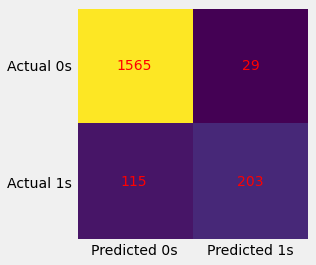

TNR = 0.9818 Specificity, proportion of the negative class 0 got correctly classified.
FNR = 0.3616 or Type II Error: Proportion of the positive class 1 got incorrectly classified.
Accuracy = 0.9247: Percentage of total items classified correctly
FPR = 0.0182 Specificity, or Type I Error: proportion of the negative class 0 got incorrectly classified.
TPR = 0.6384 Recall, sensitivity, proportion of the positive class 1 got correctly classified.
Precision = 0.875
F1 score = 0.7382: harmonic mean of precision and recall.
MCC = 0.7072 Matthews correlation coefficient: accounts for all 4 confusion matrix categories.
              precision    recall  f1-score   support

           0       0.93      0.98      0.96      1594
           1       0.88      0.64      0.74       318

    accuracy                           0.92      1912
   macro avg       0.90      0.81      0.85      1912
weighted avg       0.92      0.92      0.92      1912



In [324]:
y_predicted = model_nosplit.predict(X) # Predicted labels
# Evaluate the Model
tn,fp,fn,tp = confusion_matrix_plot(y, y_predicted)
metrics(y, y_predicted, tn,fp,fn,tp)
accuracy_nosplit = accuracy_score(y, y_predicted)
print(classification_report(y, y_predicted))

In [316]:
print("Distinct values that y takes:",log_reg_nosplit.classes_)
# probability of y=0 (1st column) and y=1 (2nd column)
print("Prediction Probabilities (top):\n", log_reg_nosplit.predict_proba(X)[:3])
print("Regression Coefficients:\n")
b0_nosplit = log_reg_nosplit.intercept_[0]
print("Intercept b0 =", b0_nosplit)
b_nosplit = log_reg_nosplit.coef_
print("Coefficients b =", b_nosplit)

Distinct values that y takes: [0 1]
Prediction Probabilities (top):
 [[0.90947873 0.09052127]
 [0.02638061 0.97361939]
 [0.99816916 0.00183084]]
Regression Coefficients:

Intercept b0 = 0.11171657443299718
Coefficients b = [[ 2.29989044e-01 -1.04518161e-01 -8.29231298e-02 -7.76961441e-02
   4.71942792e-01  6.30319720e-02 -4.24852560e-01  1.62506936e-01
   2.78858613e-01 -8.33345036e-04 -1.36992775e-01  1.39715013e-01
  -1.78970845e-01  1.17244978e-01  4.33343929e-01  7.65127479e-02
  -1.23379214e-01  1.00013090e-01  5.03589379e-02 -8.81635305e-01
   4.29194876e-01  8.56720795e-02  3.59961155e-01 -2.84239095e-01
  -2.60855262e-01 -1.25039613e+00  4.32668263e-01 -1.00795918e-01
   2.24636840e-01 -4.34042455e-01 -9.27473983e-01 -2.58690485e-01
   7.48344330e-02  4.58382582e-01 -8.71894030e-01 -1.02606574e+00
  -1.47787117e-02 -3.99818689e-01  2.66743869e-01  2.05864315e-01
  -2.62559815e-01 -7.00605301e-02  3.17270917e-01  4.23125847e-01
  -3.72273824e-01  1.16581497e+00 -5.27412654e-01  

#### 3.2.2 Training with splitting
Taking 70% for training set and 30% for test set.

In [317]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print("Train samples:",y_train.shape[0])
print("Test samples:",y_test.shape[0])

Train samples: 1338
Test samples: 574


In [318]:
# Create and train the Logistic Regression model
#solver : {'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'}
log_reg_split = LogisticRegression(solver='lbfgs', random_state=0); # Create a model
log_reg_split.fit(X_train, y_train); # Train model using training set

[[TN, FP], [FN, TP]] =
 [[466  12]
 [ 40  56]]


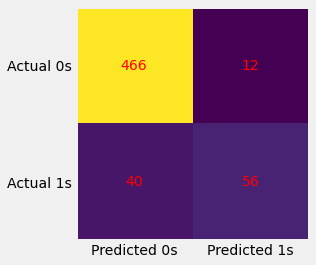

TNR = 0.9749 Specificity, proportion of the negative class 0 got correctly classified.
FNR = 0.4167 or Type II Error: Proportion of the positive class 1 got incorrectly classified.
Accuracy = 0.9094: Percentage of total items classified correctly.
FPR = 0.0251 Specificity, or Type I Error: proportion of the negative class 0 got incorrectly classified.
TPR = 0.5833 Recall, sensitivity, proportion of the positive class 1 got correctly classified.
Precision = 0.8235
F1 score = 0.6829: harmonic mean of precision and recall.
MCC = 0.6447 Matthews correlation coefficient: accounts for all 4 confusion matrix categories.
              precision    recall  f1-score   support

           0       0.92      0.97      0.95       478
           1       0.82      0.58      0.68        96

    accuracy                           0.91       574
   macro avg       0.87      0.78      0.82       574
weighted avg       0.90      0.91      0.90       574



In [319]:
y_pred_split = log_reg_split.predict(X_test) # predicted values
tn,fp,fn,tp = confusion_matrix_plot(y_test, y_pred_split)
metrics(y_test, y_pred_split, tn,fp,fn,tp)
print(classification_report(y_test, y_pred_split))

In [320]:
print("Distinct values that y takes:",log_reg_split.classes_)
# probability of y=0 (1st column) and y=1 (2nd column)
print("Prediction Probabilities (top):\n", log_reg_split.predict_proba(X_test)[:3])
print("Regression Coefficients:\n")
b0_split = log_reg_split.intercept_[0]
print("Intercept b0 =", b0_split)
b_split = log_reg_split.coef_
print("Coefficients b =", b_split)

Distinct values that y takes: [0 1]
Prediction Probabilities (top):
 [[0.63094851 0.36905149]
 [0.91142576 0.08857424]
 [0.98144328 0.01855672]]
Regression Coefficients:

Intercept b0 = 0.2662117679027964
Coefficients b = [[ 3.04156850e-01  2.55983127e-02 -9.67334929e-02 -3.65241851e-01
   5.79997908e-01 -1.21932546e-01 -5.37619578e-01 -8.33357219e-02
  -3.70807788e-01 -1.70656582e-01 -1.16929108e-01  1.99377425e-01
   6.53832185e-02  2.40553772e-01  4.59132919e-01  0.00000000e+00
   4.94447192e-01 -2.22831970e-02  1.92204738e-01 -6.75288829e-01
   1.51781543e-02  0.00000000e+00  3.25286492e-01 -1.81030017e-01
  -2.81216987e-01 -1.17888384e+00  5.35885697e-01  1.45810877e-01
   3.21890033e-01 -2.47999727e-01 -9.39009603e-01  1.92032704e-01
  -1.70305081e-01  3.85807624e-01 -5.23711475e-01 -6.34080689e-01
  -2.38392576e-01 -2.00466104e-01 -2.53189154e-01  2.15870049e-01
   3.35491912e-02  7.51470519e-02  4.22668183e-01 -1.11843697e-01
  -4.02739035e-01  5.14267506e-01 -1.73520108e-01  2

#### Comparison to no split
Quality of the model does not depend on the solver in both cases of no split and 30% test set. Compared to no splitting, many of the model coefficients differ by more than 20%,

In [325]:
print("Intercept relative error:",b0_split/b0_nosplit-1)
print("Coefficient relative error:",b_split/b_nosplit-1)

Intercept relative error: 1.3829209699090694
Coefficient relative error: [[ 3.22484081e-01 -1.24491737e+00  1.66544161e-01  3.70090060e+00
   2.28958079e-01 -2.93445552e+00  2.65426242e-01 -1.51281332e+00
  -2.32973403e+00  2.03785022e+02 -1.46457846e-01  4.27029356e-01
  -1.36532888e+00  1.05171920e+00  5.95115977e-02 -1.00000000e+00
  -5.00754045e+00 -1.22280281e+00  2.81669563e+00 -2.34049698e-01
  -9.64635751e-01 -1.00000000e+00 -9.63289018e-02 -3.63106551e-01
   7.80575575e-02 -5.71917080e-02  2.38560216e-01 -2.44659505e+00
   4.32935191e-01 -4.28627951e-01  1.24376753e-02 -1.74232612e+00
  -3.27575828e+00 -1.58328351e-01 -3.99340450e-01 -3.82027227e-01
   1.51308090e+01 -4.98607470e-01 -1.94918453e+00  4.86035384e-02
  -1.12777733e+00 -2.07260182e+00  3.32199583e-01 -1.26432726e+00
   8.18354915e-02 -5.58877249e-01 -6.70997450e-01 -2.44419386e-01
   9.05216101e-01  5.74923035e+00  2.03507785e+00  5.74230446e-02
  -1.23038454e-02 -1.21771728e-01 -1.78107898e-01  1.15597911e-01
  -

and all quality metrics are considerably worse than for no split (Accuracy is 1.65% lower, FPR is 37.9% higher, TPR is 8.69% lower, Precision is 5.89% lower, F1 score is 7.49% lower, and MCC is 8.84% lower).

In [326]:
print("Relative difference in accuracy =", accuracy_split/accuracy_nosplit-1)

Relative difference in accuracy = -0.01652293187443843


The change in the proportion of positive values 1 of the label `is_churn` in the test dataset compared to the full dataset is only 0.56%,

In [241]:
print("Proportion of `is_churn==1` in the full set:", np.sum(y)/len(y))

Proportion of `is_churn==1` in the full set: 0.16631799163179917


In [242]:
print("Proportion of `is_churn==1` in the test set:", np.sum(y_test)/len(y_test))

Proportion of `is_churn==1` in the test set: 0.1672473867595819


so this is not the reason for the large reduction in model quality.

#### 3.2.3 Optimization of the regularization parameter C
Let's try to adjust the regularization strength C.

In [328]:
def opt_C(Cmin,Cmax,Cstep):
    '''Optimize regularization parameter C by maximizing accuracy in Logistic Regression for Train-Test split.'''
    accuracy = pd.DataFrame({'C':[],'Accuracy':[]})
    acc_opt = 0
    for C in np.arange(Cmin, Cmax+Cstep, Cstep):
        log_reg_C = LogisticRegression(C=C, random_state=0, max_iter=3000)
        log_reg_C.fit(X_train, y_train)
        pred = log_reg_C.predict(X_test) # predicted values
        acc = log_reg_C.score(X_test, y_test) # proportion of correct predictions
        accuracy = accuracy.append({'C':C,'Accuracy':acc}, ignore_index=True)
        if acc_opt < acc:
            acc_opt = acc
            C_opt = C
    print('Optimal C =',C_opt)
    print('Highest accuracy =',acc_opt)
    fig, axs = plt.subplots(figsize = (16,8))
    plt.scatter(accuracy['C'],accuracy['Accuracy']);
    plt.xlabel('C');
    plt.ylabel('Accuracy');

Optimal C = 0.4
Highest accuracy = 0.9094076655052264


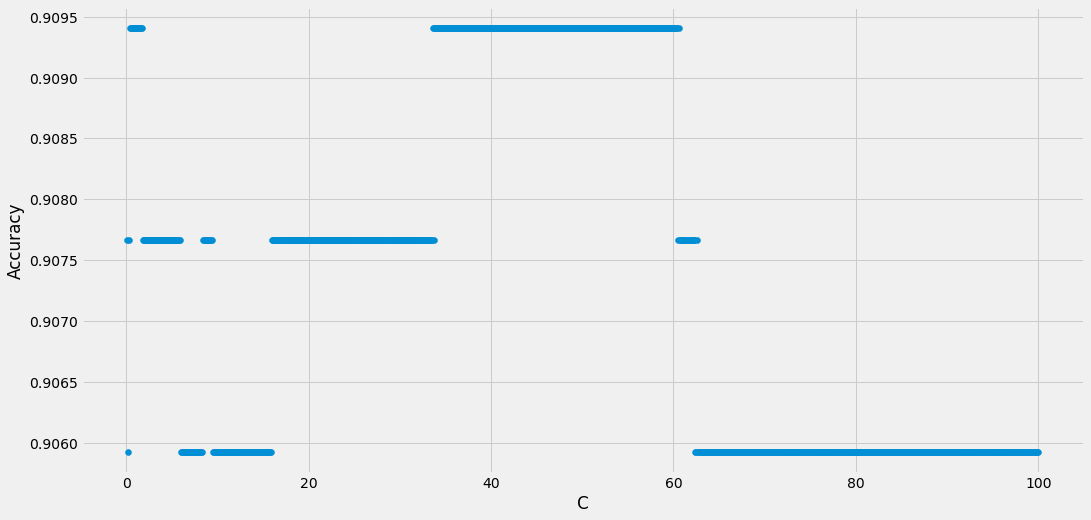

In [153]:
opt_C(0.1,100,0.1)

Optimal C = 0.4
Highest accuracy = 0.9094076655052264


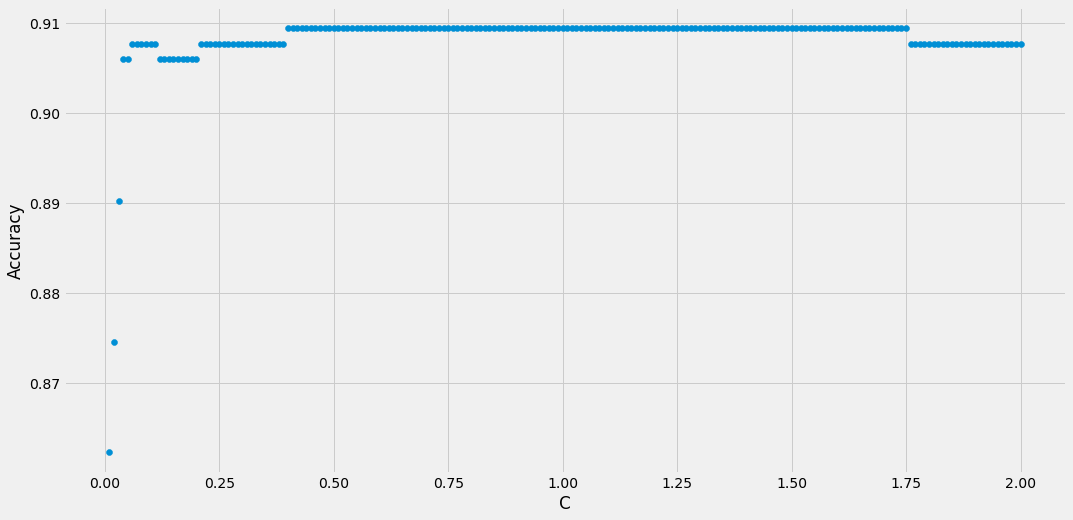

In [154]:
opt_C(0.01,2,0.01)

Optimized C in Logistic Regression with 30% test split:
Accuracy = 0.9094076655052264
[[TN, FP], [FN, TP]] =
 [[466  12]
 [ 40  56]]


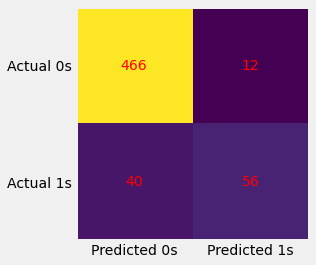

TNR = 0.9749 Specificity, proportion of the negative class 0 got correctly classified.
FNR = 0.4167 or Type II Error: Proportion of the positive class 1 got incorrectly classified.
Accuracy = 0.9094: Percentage of total items classified correctly
FPR = 0.0251 Specificity, or Type I Error: proportion of the negative class 0 got incorrectly classified.
TPR = 0.5833 Recall, sensitivity, proportion of the positive class 1 got correctly classified.
Precision = 0.8235
F1 score = 0.6829: harmonic mean of precision and recall.
MCC = 0.6447 Matthews correlation coefficient: accounts for all 4 confusion matrix categories.
              precision    recall  f1-score   support

           0       0.93      0.98      0.96      1594
           1       0.88      0.64      0.74       318

    accuracy                           0.92      1912
   macro avg       0.90      0.81      0.85      1912
weighted avg       0.92      0.92      0.92      1912



In [329]:
print('Optimized C in Logistic Regression with 30% test split:')
C_opt = 1.0
log_reg_C = LogisticRegression(C=C_opt, random_state=0).fit(X_train, y_train) # Create and train model using training set
pred_C = log_reg_C.predict(X_test) # predicted values
print("Accuracy =",log_reg_C.score(X_test, y_test)) # proportion of correct predictions
tn,fp,fn,tp = confusion_matrix_plot(y_test, pred_C)
metrics(y_test, pred_C, tn,fp,fn,tp)
print(classification_report(y, y_predicted))

Optimization of the regularization parameter 'C' did not lead to an improvement in accuracy, since the accuracy and other performance metrics stay same for $C \in [0.392, 1.756]$. A way to increase recall is to adjust the threshold probability, which will be done below when considering ROC and Precision-Recall curves.

#### 3.2.4 Cross-Validation
A more reliable way of validating the model and optimizing its parameters is by cross-validation.

In [330]:
from sklearn.model_selection import cross_val_score
print("Example of cross-validation:")
log_reg_cv = LogisticRegression(random_state=0) #solver='liblinear'
scores = cross_val_score(log_reg_cv, X, y, cv=10) #X_train, y_train
print('Cross-Validation Accuracy Scores', scores)
scores.min(), scores.mean(), scores.max()

Example of cross-validation:
Cross-Validation Accuracy Scores [0.96354167 0.921875   0.91099476 0.91623037 0.89005236 0.88481675
 0.93193717 0.87434555 0.90052356 0.91623037]


(0.8743455497382199, 0.9110547556719023, 0.9635416666666666)

In [301]:
?LogisticRegression

In [331]:
def optCV_C(Cmin,Cmax,Cstep):
    '''Optimize regularization parameter C in Logistic Regression with 10-fold Cross-Validation'''
    accuracy = pd.DataFrame({'C':[],'Accuracy':[]})
    acc_opt = 0
    for C in np.arange(Cmin, Cmax+Cstep, Cstep):
        log_reg_cv = LogisticRegression(solver='lbfgs', C=C, max_iter=3000, random_state=0) #liblinear
        scores = cross_val_score(log_reg_cv, X, y, cv=10) # accuracies of cv cross-validations
        acc = scores.mean()
        accuracy = accuracy.append({'C':C,'Accuracy':acc}, ignore_index=True)
        if acc_opt < acc:
            acc_opt = acc
            C_opt = C
    print('Optimal C =',C_opt)
    print('Highest accuracy =',acc_opt)
    fig, axs = plt.subplots(figsize = (16,8))
    plt.scatter(accuracy['C'],accuracy['Accuracy']);
    plt.xlabel('C');
    plt.ylabel('Accuracy');

In [ ]:
optCV_C(0.1, 100, 0.1)

Optimal C = 0.22
Highest accuracy = 0.9162794502617801


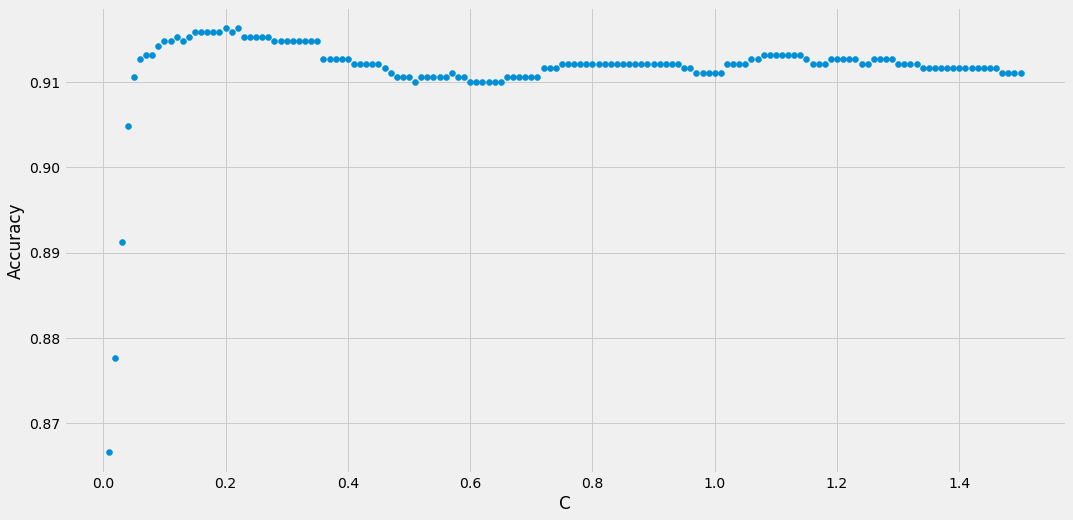

In [307]:
optCV_C(0.01, 1.5, 0.01)

Optimized C in Logistic Regression with 10-fold Cross-Validation:


LogisticRegression(C=0.22, random_state=0)

[[TN, FP], [FN, TP]] =
 [[466  12]
 [ 41  55]]


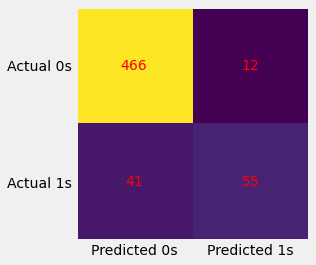

TNR = 0.9749 Specificity, proportion of the negative class 0 got correctly classified.
FNR = 0.4271 Proportion of the positive class 1 got incorrectly classified.
Accuracy = 0.9077
FPR = 0.0251 Specificity, proportion of the negative class 0 got incorrectly classified.
TPR = 0.5729 Recall, sensitivity, proportion of the positive class 1 got correctly classified.
Precision = 0.8209
F1 score = 0.6748
MCC = 0.6367 Matthews correlation coefficient: accounts for all 4 confusion matrix categories.
              precision    recall  f1-score   support

           0       0.93      0.98      0.96      1594
           1       0.88      0.64      0.74       318

    accuracy                           0.92      1912
   macro avg       0.90      0.81      0.85      1912
weighted avg       0.92      0.92      0.92      1912



In [308]:
print('Optimized C in Logistic Regression with 10-fold Cross-Validation:')
C_opt = 0.22
log_reg_cv = LogisticRegression(solver='lbfgs', C=C_opt, random_state=0) # Create a model
log_reg_cv.fit(X_train, y_train) # Train model using training set
pred_Ccv = log_reg_cv.predict(X_test) # predicted values
tn,fp,fn,tp = confusion_matrix_plot(y_test, pred_Ccv)
metrics(y_test, pred_Ccv, tn,fp,fn,tp)
print(classification_report(y, y_predicted))

The quality is only slightly lower than in the previous 30% test split optimization of 'C'.

In [92]:
print(classification_report(y_test, pred_Ccv))

              precision    recall  f1-score   support

         0.0       0.92      0.99      0.95       853
         1.0       0.88      0.47      0.61       143

    accuracy                           0.91       996
   macro avg       0.90      0.73      0.78       996
weighted avg       0.91      0.91      0.90       996



| Transactions | Cut-off date | Mode | solver | C | Accuracy | FPR | TPR | Precision | F1 | MCC |
|---:|:-------------|:-----------|:------|:------|:------|:------|:------|:------|:------|:------|
| 1 | 2016-10-22 | No Split | - | 1 | 0.9247 | 0.0182 | 0.6384 | 0.8750 | 0.7382 | 0.7072 |
| 1 | 2016-10-22 | 30% Test | - | 1 | 0.9094 | 0.0251 | 0.5833 | 0.8235 | 0.6829 | 0.6447 |
| 1 | 2016-10-22 | 30% Test, opt. C | - | 1 | 0.9094 | 0.0251 | 0.5833 | 0.8235 | 0.6829 | 0.6447 |
|---|-------------|---------|------|--------|--------|--------|--------|--------|--------|
| 1 | 2016-10-22 | cv=10 | lbfgs | 0.22 | 0.9077 | 0.0251 | 0.0251 | 0.8209 | 0.6748 | 0.6367 |
| 1 | 2016-10-22 | cv=10 | newton-cg | ?1 | 0.9094 | 0.0251 | 0.5833 | 0.8235 | 0.6829 | 0.6447 |
| 1 | 2016-10-22 | 30% Test | liblinear | 1 | 0.9094 | 0.0251 | 0.5833 | 0.8235 | 0.6829 | 0.6447 |
| 1 | 2016-10-22 | 30% Test | sag | 1 | 0.9094 | 0.0251 | 0.5833 | 0.8235 | 0.6829 | 0.6447 |
| 1 | 2016-10-22 | 30% Test | saga | 1 | 0.9094 | 0.0251 | 0.5833 | 0.8235 | 0.6829 | 0.6447 |

In [296]:
C_opt

1.0

In [103]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
print('Recall =', recall_score(y_test, pred_cv))
# tpr = tp/(tp + fn) Recall, sensitivity, proportion of the positive class 1 got correctly classified.
print('Precision =', precision_score(y_test, pred_cv))
print('F1 score =', f1_score(y_test, pred_cv))
fnr = fn_Ccv/(tp_cv + fn_Ccv)
print(f"FNR = {round(fnr,4)} Proportion of the positive class 1 got incorrectly classified.")
tnr = tn_Ccv/(tn_cv + fp_Ccv)
print(f"TNR = {round(tnr,4)} Specificity, proportion of the negative class 0 got correctly classified.")
fpr = fp_Ccv/(tn_cv + fp_cv)
print(f"FPR = {round(fpr,4)} Specificity, proportion of the negative class 0 got incorrectly classified.")
MCC = (tp_Ccv*tn_Ccv-fp_Ccv*fn_Ccv)/np.sqrt((tp_Ccv+fp_Ccv)*(tp_Ccv+fn_Ccv)*(tn_Ccv+fp_Ccv)*(tn_Ccv+fn_Ccv))
print(f"MCC = {round(MCC,4)} Matthews correlation coefficient: accounts for all 4 confusion matrix categories.")

Recall = 0.46853146853146854
Precision = 0.881578947368421
F1 score = 0.6118721461187215
FNR = 0.5315 Proportion of the positive class 1 got incorrectly classified.
TNR = 0.9894 Specificity, proportion of the negative class 0 got correctly classified.
FPR = 0.0106 Specificity, proportion of the negative class 0 got incorrectly classified.
MCC = 0.6049 Matthews correlation coefficient.


F1 score is very sensitive to what is called a positive and a negative class. MCC is preferable. Since we want to correctly classify the positive class `is_churn == 1`, a higher TPR and a lower FNR is desirable.

#### 3.1.5 ROC - AUC, Optimization of classification threshold
Area Under the Curve (AUC) of Receiver Characteristic Operator (ROC) helps us visualize how well our machine learning classifier is performing and choose the optimal classification threshold probability.

https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/

https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/

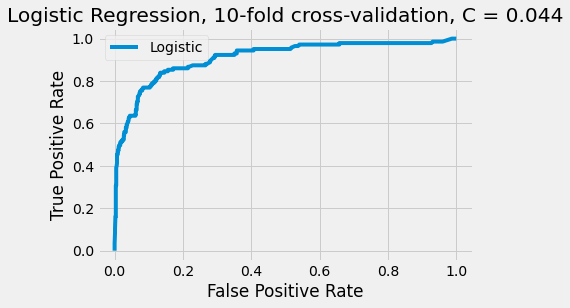

In [113]:
prob_cv = log_reg_cv.predict_proba(X_test)[:,1]
fpr, tpr, thresh = roc_curve(y_test, prob_cv, pos_label=1, drop_intermediate=False)
plt.plot(fpr, tpr, linestyle='-', label='Logistic')
# axis labels
plt.title('Logistic Regression, 10-fold cross-validation, C = 0.044')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend() # show the legend
plt.show()

ROC curve built manually:

FPR = [1.         1.         1.         0.9144197  0.57327081 0.41031653
 0.38569754 0.36694021 0.35756155 0.35756155 0.35287222 0.34818288
 0.33177022 0.30715123 0.28956624 0.23446659 0.1852286  0.16178195
 0.13716295 0.11957796 0.10433763 0.09378664 0.08675264 0.07737397
 0.07620164 0.07385698 0.07385698 0.07385698 0.07268464 0.06799531
 0.06565064 0.06447831 0.06213365 0.06096131 0.05275498 0.04454865
 0.03634232 0.03282532 0.02813599 0.02344666 0.01875733 0.01641266
 0.01289566 0.01289566 0.01289566 0.01172333 0.01172333 0.01172333
 0.010551   0.010551   0.010551   0.00937866 0.00937866 0.00937866
 0.00937866 0.00937866 0.00937866 0.00937866 0.00820633 0.00820633
 0.00820633 0.00820633 0.00820633 0.00820633 0.00820633 0.00820633
 0.00820633 0.007034   0.007034   0.007034   0.007034   0.007034
 0.007034   0.00468933 0.00468933 0.00468933 0.00468933 0.00234467
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.    

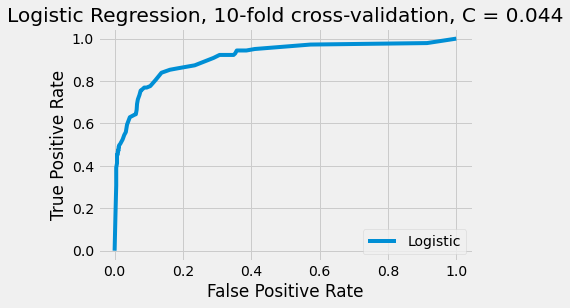

In [114]:
pred_prob = log_reg_cv.predict_proba(X_test) # probability of y=0 (1st column) and y=1 (2nd column)
prob_step = 0.01
fpr = np.empty(int(1+1/prob_step))
tpr = np.empty(int(1+1/prob_step))
j = 0 # counter of points
thresholds = np.arange(0, 1+prob_step, prob_step)
for prob_thresh in thresholds:
    tn = 0; fn = 0; tp = 0; fp = 0;
    for i in range(pred_cv.shape[0]): # each test case
        if pred_prob[i,1] >= prob_thresh: # classify as 1
            if y_test[i] == 0: # actual 0
                fp = fp+1
            else: # actual 1
                tp = tp+1
        else: # classify as 0
            if y_test[i] == 0: # actual 0
                tn = tn+1
            else: # actual 1
                fn = fn+1
    fpr[j] = fp/(tn + fp) # specificity
    tpr[j] = tp/(tp + fn) # sensitivity
    j = j+1
print("FPR =",fpr)
print("TPR =",fpr)
# ROC curve
plt.plot(fpr, tpr, linestyle='-', label='Logistic')
plt.title('Logistic Regression, 10-fold cross-validation, C = 0.044')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend() # show the legend
plt.show()

In [115]:
auc_score = roc_auc_score(y_test, pred_prob[:,1])
print("auc_score =",auc_score)

auc_score = 0.910017298059502


One of the ways to locate the optimal threshold with the optimal balance between false positive and true positive rates is using the Geometric Mean (`roc_auc_score`). Let's use the squared geometric mean, which corresponds to the area to the bottom and right from the point on the ROC curve.

In [120]:
# calculate the squared g-mean for each threshold
gmeans_sq = tpr * (1-fpr)
# locate the index of the largest g-mean
ix = np.argmax(gmeans_sq)
print('Best Threshold = %.2f, G-Mean_sq = %.3f' % (thresholds[ix], gmeans_sq[ix]))
print('FPR = %.3f, TPR = %.3f' % (fpr[ix], tpr[ix]))

Best Threshold = 0.18, G-Mean_sq = 0.724
FPR = 0.137, TPR = 0.839


In [121]:
from sklearn.metrics import accuracy_score, recall_score, precision_score
preds = np.where(log_reg_cv.predict_proba(X_test)[:,1] > thresholds[ix], 1, 0)
pd.DataFrame(data=[accuracy_score(y_test, preds), recall_score(y_test, preds),
                   precision_score(y_test, preds), roc_auc_score(y_test, preds)], 
             index=["accuracy", "recall", "precision", "roc_auc_score"])

,0
accuracy,0.859438
recall,0.839161
precision,0.506329
roc_auc_score,0.850999


In [145]:
mt_cut1.head()

,msno,city,bd,gender,registered_via,registration_init_time,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,discount,is_churn
0,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,13.0,28.0,female,9.0,2004-03-27,32.0,410.0,1788.0,1788.0,0.0,2015-06-16,2016-07-30,0.0,0.0,0.0
1,9N+q58Vl33+QW6zHwivroNlgJw88g9ghwX/ke+OhgtM=,15.0,0.0,female,9.0,2004-03-27,34.0,0.0,0.0,149.0,1.0,2015-03-31,2015-04-30,0.0,-149.0,1.0
2,9rzbu7TiCDnfkSXSx9O0DZhmEBSncZ0VBmS2l1b5kg8=,22.0,34.0,male,9.0,2004-03-27,37.0,31.0,149.0,149.0,1.0,2015-01-11,2015-02-12,0.0,0.0,0.0
3,/G/XFknHm94YVoCefhCyvnB9mAFM0rUSMqSNA/n+jTg=,13.0,34.0,male,9.0,2004-04-07,34.0,0.0,0.0,149.0,1.0,2015-03-31,2015-04-30,0.0,-149.0,1.0
4,BvmNMrNw/X4PB8ueWGZ0JswZoUAGGpMZET03F+rkmTI=,4.0,34.0,male,9.0,2004-05-18,32.0,410.0,1788.0,1788.0,0.0,2016-01-04,2017-02-20,0.0,0.0,0.0


In [146]:
df = mt_cut1.drop(['msno','plan_list_price','registration_init_time','transaction_date','membership_expire_date'],axis=1)
df.head()

df_dummy = pd.get_dummies(df, drop_first=True)
df_dummy.head()

,city,bd,registered_via,payment_method_id,payment_plan_days,actual_amount_paid,is_auto_renew,is_cancel,discount,is_churn,gender_male,gender_unknown
0,13.0,28.0,9.0,32.0,410.0,1788.0,0.0,0.0,0.0,0.0,0,0
1,15.0,0.0,9.0,34.0,0.0,149.0,1.0,0.0,-149.0,1.0,0,0
2,22.0,34.0,9.0,37.0,31.0,149.0,1.0,0.0,0.0,0.0,1,0
3,13.0,34.0,9.0,34.0,0.0,149.0,1.0,0.0,-149.0,1.0,1,0
4,4.0,34.0,9.0,32.0,410.0,1788.0,0.0,0.0,0.0,0.0,1,0


In [147]:
X = df_dummy.loc[df['is_churn'] != 2].drop('is_churn', axis=1) # drop unknown churn
y = df_dummy.loc[df_dummy['is_churn'] != 2, ['is_churn']]
y = np.ravel(y)

In [148]:
from sklearn.model_selection import train_test_split, cross_val_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print("Train samples:",y_train.shape[0])
print("Test samples:",y_test.shape[0])
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

Train samples: 1338
Test samples: 574


#### 3.1.6 Optimizing solver

Optimize C using 10-fold cross-validation, lbfgs solver
C = 10.0
C = 20.0
C = 30.0
C = 40.0
C = 50.0
C = 60.0
C = 70.0
C = 80.0
C = 90.0
Optimal C = 1.0
Highest accuracy = 0.8542812254516889


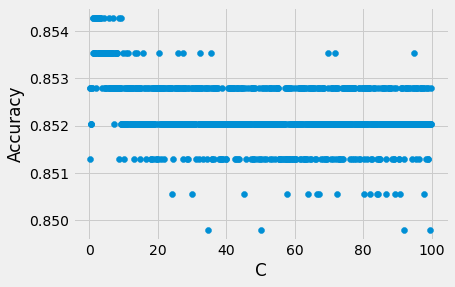

In [149]:
print('Optimize C using 10-fold cross-validation, lbfgs solver')
log_reg_lbfgs = LogisticRegression(solver='lbfgs')
accuracy = pd.DataFrame({'C':[],'Accuracy':[]})
acc_opt = 0
for C in np.arange(0.1, 100.0, 0.1):
    C = round(C,1)
    log_reg_cv_lbfgs = LogisticRegression(solver='lbfgs', C=C, random_state=0, max_iter=3000)
    scores = cross_val_score(log_reg_cv_lbfgs, X_train, y_train, cv=10) # accuracies of cv cross-validations
    acc = scores.mean()
    accuracy = accuracy.append({'C':C,'Accuracy':acc}, ignore_index=True)
    if acc_opt < acc:
        acc_opt = acc
        C_opt = C
    if C % 10 == 0: print("C =",C)
print('Optimal C =',C_opt)
print('Highest accuracy =',acc_opt)
plt.scatter(accuracy['C'],accuracy['Accuracy']);
plt.xlabel('C');
plt.ylabel('Accuracy');

We see a "ship" with the highest accuracy 0.8543 at C = 1.0.

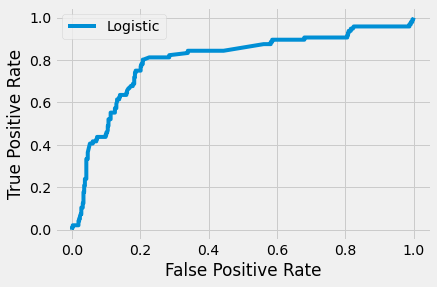

In [150]:
log_reg_cv_lbfgs = LogisticRegression(solver='lbfgs', C=C_opt, random_state=0, max_iter=3000)
log_reg_cv_lbfgs.fit(X_train,y_train) # train
pred_cv_lbfgs = log_reg_cv_lbfgs.predict_proba(X_test)
fpr_cv_lbfgs, tpr_cv_lbfgs, thresh_cv_lbfgs = roc_curve(y_test, pred_cv_lbfgs[:,1], pos_label=1, drop_intermediate=False)
plt.plot(fpr_cv_lbfgs, tpr_cv_lbfgs, linestyle='-', label='Logistic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [154]:
# calculate the squared g-mean for each threshold
gmeans_sq = tpr_cv_lbfgs * (1-fpr_cv_lbfgs)
# locate the index of the largest g-mean
ix = np.argmax(gmeans_sq)
print('Best Threshold=%.2f, G-Mean_sq=%.3f' % (thresh_cv_lbfgs[ix], gmeans_sq[ix]))
print('FPR=%.3f, TPR=%.3f' % (fpr_cv_lbfgs[ix], tpr_cv_lbfgs[ix]))

Best Threshold=0.19, G-Mean_sq=0.636
FPR=0.207, TPR=0.802


In [155]:
from sklearn.metrics import accuracy_score, recall_score, precision_score
THRESHOLD = 0.19
preds = np.where(log_reg_cv_lbfgs.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)
pd.DataFrame(data=[accuracy_score(y_test, preds), recall_score(y_test, preds),
                   precision_score(y_test, preds), roc_auc_score(y_test, preds)], 
             index=["accuracy", "recall", "precision", "roc_auc_score"])

,0
accuracy,0.794425
recall,0.802083
precision,0.437500
roc_auc_score,0.797485


In [159]:
print(f"Accuracy relative change: {round(accuracy_score(y_test, preds)/0.777003-1,4)}")
print(f"Recall: {round(recall_score(y_test, preds)/0.812500-1,4)}")
print(f"Precision: {round(precision_score(y_test, preds)/0.414894-1,4)}")
print(f"ROC AUC: {round(roc_auc_score(y_test, preds)/0.791187-1,4)}")

Accuracy relative change: 0.0224
Recall: -0.0128
Precision: 0.0545
ROC AUC: 0.008


## 4. Feature Engineering
### 4.1 One-hot encoding
Let us convert all categorical features into dummy variables using one-hot encoding and compare performance of logistic regression.

In [163]:
df_onehot = pd.get_dummies(df, drop_first=False, columns=['city','bd','gender','registered_via','payment_method_id','is_auto_renew','is_cancel','discount'])
df_onehot.head()

,payment_plan_days,actual_amount_paid,is_churn,city_0.0,city_1.0,city_3.0,city_4.0,city_5.0,city_6.0,city_7.0,...,discount_-894.0,discount_-799.0,discount_-150.0,discount_-149.0,discount_-129.0,discount_-50.0,discount_0.0,discount_20.0,discount_30.0,discount_149.0
0,410.0,1788.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0.0,149.0,1.0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,31.0,149.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0.0,149.0,1.0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,410.0,1788.0,0.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [164]:
x = df_onehot.drop('is_churn', axis=1)
print(f"Samples: {x.shape[0]}, explanatory variables: {x.shape[1]}")
y = df_onehot['is_churn']
#y.head()

Samples: 2085, explanatory variables: 123


In [165]:
#from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
print("Train samples:",y_train.shape[0])
print("Test samples:",y_test.shape[0])

Train samples: 1459
Test samples: 626


Optimize C using cross-validation
Optimal C = 0.8
Highest accuracy = 0.8361738308927726


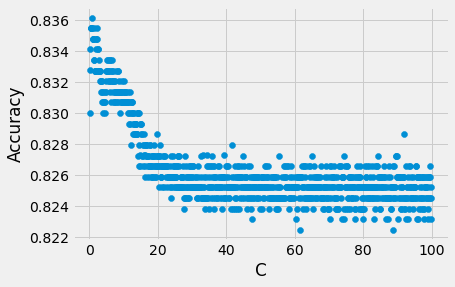

In [70]:
print('Optimize C using cross-validation')
accuracy = pd.DataFrame({'C':[],'Accuracy':[]})
acc_opt = 0
for C in np.arange(0.1, 100.0, 0.1):
    C = round(C,1)
    log_reg_cv = LogisticRegression(solver='liblinear', C=C, random_state=0)
    scores = cross_val_score(log_reg_cv, X_train, y_train, cv=10) # accuracies of cv cross-validations
    acc = scores.mean()
    accuracy = accuracy.append({'C':C,'Accuracy':acc}, ignore_index=True)
    if acc_opt < acc:
        acc_opt = acc
        C_opt = C
print('Optimal C =',C_opt)
print('Highest accuracy =',acc_opt)
plt.scatter(accuracy['C'],accuracy['Accuracy']);
plt.xlabel('C');
plt.ylabel('Accuracy');

C:\Programs\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


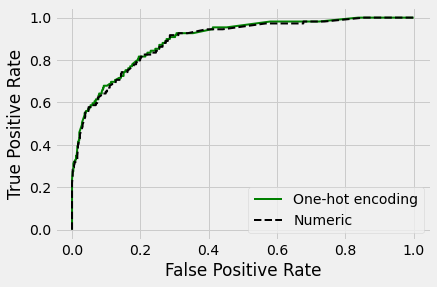

In [81]:
log_reg_cv_liblinear_onehot = LogisticRegression(solver='lbfgs', C=C_opt, random_state=0, max_iter=3000)
log_reg_cv_liblinear_onehot.fit(X_train,y_train) # train
pred_cv_liblinear_onehot = log_reg_cv_liblinear_onehot.predict_proba(X_test)
fpr_cv_liblinear_onehot, tpr_cv_liblinear_onehot, thresh_cv_liblinear_onehot = roc_curve(y_test, pred_cv_liblinear_onehot[:,1], pos_label=1, drop_intermediate=False)
plt.plot(fpr_cv_liblinear_onehot, tpr_cv_liblinear_onehot, linestyle='-', color='green', linewidth=2, label='One-hot encoding')
plt.plot(fpr_cv_lbfgs, tpr_cv_lbfgs, linestyle='--', linewidth=2, color='black', label='Numeric')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

ROC curve for one-hot encoding is very close to the case when all features except gender were used in their numeric encoding. In addition, the optimal threshold value has not changed after switching to one-hot encoding.

In [89]:
# calculate the squared g-mean for each threshold
gmeans_sq = tpr_cv_liblinear_onehot * (1-fpr_cv_liblinear_onehot)
# locate the index of the largest g-mean
ix = np.argmax(gmeans_sq)
print('Best Threshold=%.2f, G-Mean_sq=%.3f' % (thresh_cv_liblinear_onehot[ix], gmeans_sq[ix]))
print('FPR=%.3f, TPR=%.3f' % (fpr[ix], tpr[ix]))

print(f"Relative change in G-Mean_sq: {round(gmeans_sq[ix]/0.627-1,4)}")
print(f"Relative change in FPR: {round(fpr[ix]/0.228-1,4)}")
print(f"Relative change in TPR: {round(tpr[ix]/0.812-1,4)}")

Best Threshold=0.16, G-Mean_sq=0.657
FPR=0.195, TPR=0.817
Relative change in G-Mean_sq: 0.0478
Relative change in FPR: -0.1432
Relative change in TPR: 0.0056


## RESTART

In [63]:
import os
#os.chdir('C:/Sereda/Lectures/Springboard/16.Feature_Engineering/')
os.chdir('C:/Sereda/Lectures/Springboard/Capstone2_CustomerChurn/')

# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings from pandas
#import warnings
#warnings.filterwarnings('ignore')

from pathlib import Path

plt.style.use('fivethirtyeight')
pd.set_option('display.max_rows', 600)

mt = pd.read_csv('data/members_transactions.csv', \
                 parse_dates=['registration_init_time','transaction_date', 'membership_expire_date'], \
                      infer_datetime_format = True, index_col=None)
logs_short = pd.read_csv('data/logs_short.csv', parse_dates=['date'], infer_datetime_format = True)

latest_date = np.max(mt.transaction_date)
print(f"Latest recorded transaction: {latest_date.strftime('%Y-%m-%d')}")
#cutoff_date = latest_date
cutoff_date = pd.Timestamp('2016-10-22')
print("Applying cutoff time", cutoff_date.strftime('%Y-%m-%d'))
mt_cut = mt.loc[mt.transaction_date <= cutoff_date]
print("No. of records:", len(mt_cut))
member_list = mt_cut['msno'].unique() # list of all member id's
print("No. of members:", len(member_list))
mt_cut.head()

Latest recorded transaction: 2017-03-31
Applying cutoff time 2016-10-22
No. of records: 17298
No. of members: 2085


,msno,city,bd,gender,registered_via,registration_init_time,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,discount,is_churn
0,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,13.0,28.0,female,9.0,2004-03-27,32,410,1788,1788,0,2015-06-16,2016-07-30,0,0,0
1,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,13.0,28.0,female,9.0,2004-03-27,38,30,149,149,0,2016-08-01,2016-08-31,0,0,0
2,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,13.0,28.0,female,9.0,2004-03-27,38,30,149,149,0,2016-09-13,2016-10-13,0,0,0
4,9N+q58Vl33+QW6zHwivroNlgJw88g9ghwX/ke+OhgtM=,15.0,0.0,female,9.0,2004-03-27,34,0,0,149,1,2015-03-31,2015-04-30,0,-149,1
5,9N+q58Vl33+QW6zHwivroNlgJw88g9ghwX/ke+OhgtM=,15.0,0.0,female,9.0,2004-03-27,34,0,0,149,1,2015-06-30,2015-07-31,0,-149,0


### 4.2 More than one transaction per member
Now let's introduce features in cases when a member had more than one transaction. Due to the dependence of the number of features on the number of transactions, we have to keep the number of transactions fixed. Consider 2 transactions per member. All members with only 1 transaction are disregarded.

In [64]:
# Select only first `n_trans` transaction for each member
n_trans=1
mt_cutn = pd.DataFrame({'msno':[],'city':[],'bd':[],'gender':[],'registered_via':[],'registration_init_time':[],'payment_method_id':[],'payment_plan_days':[],'plan_list_price':[],'actual_amount_paid':[],'is_auto_renew':[],'transaction_date':[],'membership_expire_date':[],'is_cancel':[],'discount':[],'is_churn':[]})
for member_id in member_list:
    member_transactions = mt_cut.loc[mt_cut['msno'] == member_id]
    if len(member_transactions) >= n_trans:
        tr = member_transactions.head(n_trans)
        #mt_cut1.loc[len(mt_cut1.index)] = [tr['msno'],tr['city'].iloc[0],0,0,0,0,0,0,0,0,0,0,0,0,0]n
        mt_cutn = mt_cutn.append(tr, ignore_index = True)
print(mt_cutn.shape)
mt_cutn.head()

(2085, 16)


,msno,city,bd,gender,registered_via,registration_init_time,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,discount,is_churn
0,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,13.0,28.0,female,9.0,2004-03-27,32.0,410.0,1788.0,1788.0,0.0,2015-06-16,2016-07-30,0.0,0.0,0.0
1,9N+q58Vl33+QW6zHwivroNlgJw88g9ghwX/ke+OhgtM=,15.0,0.0,female,9.0,2004-03-27,34.0,0.0,0.0,149.0,1.0,2015-03-31,2015-04-30,0.0,-149.0,1.0
2,9rzbu7TiCDnfkSXSx9O0DZhmEBSncZ0VBmS2l1b5kg8=,22.0,34.0,male,9.0,2004-03-27,37.0,31.0,149.0,149.0,1.0,2015-01-11,2015-02-12,0.0,0.0,0.0
3,/G/XFknHm94YVoCefhCyvnB9mAFM0rUSMqSNA/n+jTg=,13.0,34.0,male,9.0,2004-04-07,34.0,0.0,0.0,149.0,1.0,2015-03-31,2015-04-30,0.0,-149.0,1.0
4,BvmNMrNw/X4PB8ueWGZ0JswZoUAGGpMZET03F+rkmTI=,4.0,34.0,male,9.0,2004-05-18,32.0,410.0,1788.0,1788.0,0.0,2016-01-04,2017-02-20,0.0,0.0,0.0


In [65]:
df = mt_cutn.drop(['msno','plan_list_price','registration_init_time','transaction_date','membership_expire_date'],axis=1)
print(df.shape)
df.head()

(2085, 11)


,city,bd,gender,registered_via,payment_method_id,payment_plan_days,actual_amount_paid,is_auto_renew,is_cancel,discount,is_churn
0,13.0,28.0,female,9.0,32.0,410.0,1788.0,0.0,0.0,0.0,0.0
1,15.0,0.0,female,9.0,34.0,0.0,149.0,1.0,0.0,-149.0,1.0
2,22.0,34.0,male,9.0,37.0,31.0,149.0,1.0,0.0,0.0,0.0
3,13.0,34.0,male,9.0,34.0,0.0,149.0,1.0,0.0,-149.0,1.0
4,4.0,34.0,male,9.0,32.0,410.0,1788.0,0.0,0.0,0.0,0.0


In [66]:
print("Reshape features to have one row per member")
# Column names for all features in all transactions
columns = list(['city','bd','gender','registered_via'])
for i in range(1,n_trans+1):
    for col in ['payment_method_id','payment_plan_days','actual_amount_paid','is_auto_renew','is_cancel','discount']:
        columns.append(col+str(i))
columns.append('is_churn')
print(columns)
mt_cutn = pd.DataFrame(columns=columns)
for i in range(df.shape[0]//n_trans): # members
    tr_all = df.iloc[i * n_trans, 0:4] # common columns for all transactions
    for t in range(n_trans):
        tr_all = np.concatenate((tr_all, df.iloc[i * n_trans + t, 4:10]), axis=0)
    tr_all = np.concatenate((tr_all, df.iloc[(i+1) * n_trans - 1, 10:11]), axis=0)
    tr_all = pd.DataFrame(tr_all, index=columns).transpose()
    mt_cutn = mt_cutn.append(tr_all)
mt_cutn.head()

Reshape features to have one row per member
['city', 'bd', 'gender', 'registered_via', 'payment_method_id1', 'payment_plan_days1', 'actual_amount_paid1', 'is_auto_renew1', 'is_cancel1', 'discount1', 'is_churn']


,city,bd,gender,registered_via,payment_method_id1,payment_plan_days1,actual_amount_paid1,is_auto_renew1,is_cancel1,discount1,is_churn
0,13.0,28.0,female,9.0,32.0,410.0,1788.0,0.0,0.0,0.0,0.0
0,15.0,0.0,female,9.0,34.0,0.0,149.0,1.0,0.0,-149.0,1.0
0,22.0,34.0,male,9.0,37.0,31.0,149.0,1.0,0.0,0.0,0.0
0,13.0,34.0,male,9.0,34.0,0.0,149.0,1.0,0.0,-149.0,1.0
0,4.0,34.0,male,9.0,32.0,410.0,1788.0,0.0,0.0,0.0,0.0


In [67]:
mt_cutn_onehot = pd.get_dummies(mt_cutn, drop_first=False, columns=mt_cutn.columns.drop('is_churn'))
print("No. of predictors:", mt_cutn_onehot.shape[1]-1)
mt_cutn_onehot.head()

No. of predictors: 162


,is_churn,city_0.0,city_1.0,city_3.0,city_4.0,city_5.0,city_6.0,city_7.0,city_8.0,city_9.0,...,discount1_-894.0,discount1_-799.0,discount1_-150.0,discount1_-149.0,discount1_-129.0,discount1_-50.0,discount1_0.0,discount1_20.0,discount1_30.0,discount1_149.0
0,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
0,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
0,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
0,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
0,0.0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [68]:
X = mt_cutn_onehot.loc[mt_cutn_onehot['is_churn'] != 2].drop('is_churn', axis=1) # drop unknown churn
X.head()

,city_0.0,city_1.0,city_3.0,city_4.0,city_5.0,city_6.0,city_7.0,city_8.0,city_9.0,city_10.0,...,discount1_-894.0,discount1_-799.0,discount1_-150.0,discount1_-149.0,discount1_-129.0,discount1_-50.0,discount1_0.0,discount1_20.0,discount1_30.0,discount1_149.0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [69]:
y = mt_cutn_onehot.loc[mt_cutn_onehot['is_churn'] != 2, ['is_churn']]
y = np.ravel(y)
y[:5]

array([0.0, 1.0, 0.0, 1.0, 0.0], dtype=object)

### 4.3 Add useful features
Let us now add some useful features, such as registration weekday and last transaction weekday.

In [70]:
mt.head()

,msno,city,bd,gender,registered_via,registration_init_time,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,discount,is_churn
0,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,13.0,28.0,female,9.0,2004-03-27,32,410,1788,1788,0,2015-06-16,2016-07-30,0,0,0
1,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,13.0,28.0,female,9.0,2004-03-27,38,30,149,149,0,2016-08-01,2016-08-31,0,0,0
2,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,13.0,28.0,female,9.0,2004-03-27,38,30,149,149,0,2016-09-13,2016-10-13,0,0,0
3,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,13.0,28.0,female,9.0,2004-03-27,32,415,1599,1599,0,2016-10-23,2017-12-12,0,0,1
4,9N+q58Vl33+QW6zHwivroNlgJw88g9ghwX/ke+OhgtM=,15.0,0.0,female,9.0,2004-03-27,34,0,0,149,1,2015-03-31,2015-04-30,0,-149,1


In [72]:
registration_weekday = mt['registration_init_time'].dt.dayofweek
mt['registration_weekday'] = registration_weekday
mt.head()

,msno,city,bd,gender,registered_via,registration_init_time,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,discount,is_churn,registration_weekday
0,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,13.0,28.0,female,9.0,2004-03-27,32,410,1788,1788,0,2015-06-16,2016-07-30,0,0,0,5
1,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,13.0,28.0,female,9.0,2004-03-27,38,30,149,149,0,2016-08-01,2016-08-31,0,0,0,5
2,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,13.0,28.0,female,9.0,2004-03-27,38,30,149,149,0,2016-09-13,2016-10-13,0,0,0,5
3,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,13.0,28.0,female,9.0,2004-03-27,32,415,1599,1599,0,2016-10-23,2017-12-12,0,0,1,5
4,9N+q58Vl33+QW6zHwivroNlgJw88g9ghwX/ke+OhgtM=,15.0,0.0,female,9.0,2004-03-27,34,0,0,149,1,2015-03-31,2015-04-30,0,-149,1,5


In [ ]:
# Save data
if not Path("./data/mt.csv").is_file():
    mt.to_csv("./data/mt.csv", index=False)

### 4.4 Logistic Regression with Cross-Validation and added `registration_weekday`
A more reliable way of validating the model and optimizing its parameters is by cross-validation.

#### Import `df`

In [92]:
df = pd.read_csv('data/df.csv')
df.head()

,is_churn,city_0.0,city_1.0,city_3.0,city_4.0,city_5.0,city_6.0,city_7.0,city_8.0,city_9.0,...,discount_30.0,discount_120.0,discount_149.0,registration_weekday_0.0,registration_weekday_1.0,registration_weekday_2.0,registration_weekday_3.0,registration_weekday_4.0,registration_weekday_5.0,registration_weekday_6.0
0,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


#### Trial run

In [ ]:
print('Optimize C using cross-validation')
